In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io


# from tqdm import tqdm_notebook 
from tqdm.notebook import tqdm 
import random

import sentencepiece as spm
from konlpy.tag import Mecab

# Step 1. 데이터 다운로드
   

# Step 2. 데이터 정제 및 토큰화

In [3]:
# train data load
data_dir = os.getenv('HOME')+'/aiffel/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    with open(kor_path, "r") as f: kor = f.read().splitlines()

    assert len(kor) == len(eng) # kor, eng가 같은 갯수라는 것을 검증받기 위해 적용

    cleaned_corpus = list(set(zip(eng, kor)))  # 중복된 데이터 제거
    
    return cleaned_corpus

cleaned_corpus = clean_corpus(eng_path, kor_path)
len(cleaned_corpus)

78968

In [4]:
# test data loading
data_dir = os.getenv('HOME')+'/aiffel/data'
kor_path_test =data_dir+"/korean-english-park.test.ko"
eng_path_test =data_dir+"/korean-english-park.test.en"

# 데이터 정제 및 토큰화
def clean_corpus_test(kor_path_test, eng_path_test):
    with open(eng_path_test, "r") as f: eng_test = f.read().splitlines()
    with open(kor_path_test, "r") as f: kor_test = f.read().splitlines()

    assert len(kor_test) == len(eng_test) # kor, eng가 같은 갯수라는 것을 검증받기 위해 적용

    cleaned_corpus_test = list(set(zip(eng_test, kor_test)))  # 중복된 데이터 제거
    
    return cleaned_corpus_test

cleaned_corpus_test = clean_corpus_test(eng_path_test, kor_path_test)
len(cleaned_corpus_test)

1996

In [5]:
cleaned_corpus[:5]

[('그리고 현재 그와 동료 연구진은 수컷 제비에게 인위적 화장을 시켜 예상 밖의 결과를 얻었다.',
  'And now, she and her colleagues have discovered that those artificial makeovers are having an unexpected effect.'),
 ('일본 수산청은 17일 두 사람을 즉시 석방시킬 것이라고 밝혔다.',
  'The Japanese Fisheries Agency said Thursday it would readily hand over the two men.'),
 ('홍콩 구의회 의원 선거에서 친 중국 입후보자들이 홍콩 민주화 캠프에 압도적인 표차로 승리를 거뒀다.',
  "HONG KONG, China (CNN) Pro-Beijing candidates delivered a crushing blow to Hong Kong's pro-democracy camp, sweeping up nearly a third of the district council seats up for grabs, according to election results Monday."),
 ('NATO와 아프간 협력군, 탈레반의 교전은 10만명이 살고있는 우루즈간 지방으로 번져 그 곳의 경찰서가 16일 습격당했다.',
  "In neighboring Uruzgan province's Chora district home to more than 100,000 people fighting continued between NATO and Afghan forces and militants who attacked police posts in the province's main town on Saturday."),
 ('홈런왕 베리 본즈는 경기 중 스테로이드 사용여부에 대한 수사 중 대배심에 거짓진술을 했다는 혐의에 자신은 무죄라고 항변했습니다.',
  'Home run king Barry Bonds has pleaded

In [6]:
cleaned_corpus_test[:5]

[('‘미국 국립 허리케인센터(NHC)는’ “베르타가 해안에 접근하며 높은 파도가 일고 있다”며 “아직 베르타의 위력을 예측하긴 이르다”라고 전했다.',
  'The storm¡¯s maximum sustained winds had decreased slightly throughout the day to about 85 mph (140 km/h) with higher gusts, forecasters said.'),
 ('몇 주 전 엄마가 된 제이미 린 스피어스가 자신의 ‘완벽한’출산을 회상하며 남부지방의 사커맘이 되길 원한다고 말했다.',
  'NEW YORK (CNN) Weeks after giving birth to daughter Maddie Briann, Jamie Lynn Spears is showing off the newborn, sharing memories of a "perfect" delivery and longing to be a Southern soccer mom.'),
 ('경찰은 월초 두바이 해안에서 영국인 커플이 성관계를 갖던 중 발각되어 기소되자 해변에서의 외설적 행위에 대한 단속을 시작했다.',
  'Over the past two weeks, police have detained a total of 79 people for "disturbing families enjoying the beach" with their behavior, Zuhair Haroun, a spokesman for Dubai\'s Criminal Investigation Department, said Monday.'),
 ('Unemployed Compete in Their Own 자신들만의 “올림픽”에 참가하는 실직자들\xa0 \xa0 \xa02009.05',
  "That's according to a producer who worked with the actress."),
 ('쓴 맥주, 증류주 등에 설탕을 혼합해 만든 칵테일이 처음 프랑스 항구도시

In [7]:
cleaned_corpus+=cleaned_corpus_test

In [8]:
len(cleaned_corpus)

80964

In [9]:
# 1. 모든 입력을 소문자로 변환합니다.
# 2. 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
# 3. 문장부호 양옆에 공백을 추가합니다.
# 4. 문장 앞뒤의 불필요한 공백을 제거합니다.

def preprocess_sentence(sentence):

    sentence = sentence.lower() #1
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence) #2
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) #3
    sentence = re.sub(r'[" "]+', " ", sentence) #4
    
    return sentence

In [10]:
# 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행
# 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻기
# en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게
# 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
# 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
# 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
# <PAD> : 0 / <BOS> : 1 / <EOS> : 2 / <UNK> : 3

# Sentencepiece를 활용하여 학습한 tokenizer를 생성
def generate_tokenizer(corpus, vocab_size, lang="en", pad_id=0, bos_id=1, eos_id=2, unk_id=3):

    temp_file = os.getenv('HOME') + f'/aiffel/data/corpus_{lang}.txt'     # corpus를 받아 txt파일로 저장
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    # Sentencepiece를 이용해 
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix=spm{lang}_r1 --vocab_size={vocab_size}'   # model_r1
    )
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'spm{lang}_r1.model') # model_r1

    return tokenizer

In [11]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 25000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]
    # kor, eng 나눠서 데이터 정제 후 분리
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

en_tokenizer = generate_tokenizer(eng_corpus, SRC_VOCAB_SIZE, "en")
ko_tokenizer = generate_tokenizer(kor_corpus, TGT_VOCAB_SIZE, "ko")
ko_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/data/corpus_en.txt --pad_id=0 --bos_id=1 --eos_id=2         --unk_id=3 --model_prefix=spmen_r1 --vocab_size=25000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/data/corpus_en.txt
  input_format: 
  model_prefix: spmen_r1
  model_type: UNIGRAM
  vocab_size: 25000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1


True

366
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=40189 obj=11.5092 num_tokens=427481 num_tokens/piece=10.6368
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=30141 obj=11.7003 num_tokens=454224 num_tokens/piece=15.07
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=30141 obj=11.6593 num_tokens=454228 num_tokens/piece=15.0701
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=27500 obj=11.7274 num_tokens=462250 num_tokens/piece=16.8091
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=27500 obj=11.7143 num_tokens=462258 num_tokens/piece=16.8094
trainer_interface.cc(615) LOG(INFO) Saving model: spmko_r1.model
trainer_interface.cc(626) LOG(INFO) Saving vocabs: spmko_r1.vocab


In [12]:
eng_corpus[100]

'it was passed unanimously by the security council after being revised to drop any mention of chapter seven of the un charter , which is legally binding and can authorize sanctions or even military action . '

In [13]:
kor_corpus[100]

'법적으로 구속력이 있고 제재나 심지어는 군사적 행동까지 권한 부여가 가능한 유엔 헌장 제 장의 언급을 제외한 이후 결의안은 안전보장이사회에서 만장일치로 통과되었다 . '

문장의 최단 길이: 1
문장의 최장 길이: 611
문장의 평균 길이: 135


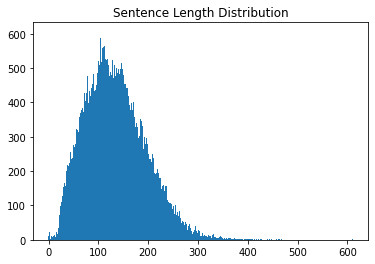

In [18]:
# eng_corpus 통계

min_len = 999
max_len = 0
sum_len = 0


for sen in eng_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(eng_corpus))

sentence_length = np.zeros((max_len), dtype=int)

#총 max_len(377, )의 배열을 만든 후, raw 문장을 돌면서 각 문장별 길이를 sentence_length의 len(sen) 인덱스마다  계속 더해가면서 counting
for sen in eng_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

문장의 최단 길이: 1
문장의 최장 길이: 331
문장의 평균 길이: 64


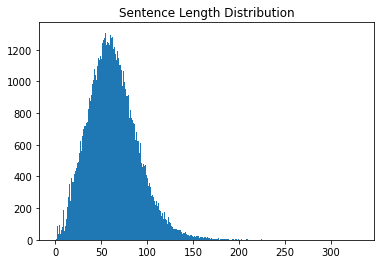

In [19]:
# kor_corpus 통계

min_len = 999
max_len = 0
sum_len = 0


for sen in kor_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(kor_corpus))

sentence_length = np.zeros((max_len), dtype=int)

#총 max_len(377, )의 배열을 만든 후, raw 문장을 돌면서 각 문장별 길이를 sentence_length의 len(sen) 인덱스마다  계속 더해가면서 counting
for sen in kor_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [ ]:
# max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
# maxlen = int(max_tokens)
# print('pad_sequences maxlen : ', maxlen)
# print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)*100}%가 maxlen 설정값 이내에 포함됩니다.')

In [21]:
# 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환
src_corpus = [] #영어
tgt_corpus = [] #한글

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 135 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    tgt = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    
    if len(src) <= 135 and len(tgt) <= 135: # enc, dec 의 seq_length는 달라도 상관없음..
        src_corpus.append(src)
        tgt_corpus.append(tgt)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_data = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_data = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/80964 [00:00<?, ?it/s]

In [22]:
# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_data, dec_data, test_size=0.2)

In [23]:
# enc, dec 의 seq_length는 달라도 상관없음.
print(enc_train.shape)
print(dec_train.shape)
print(enc_val.shape)
print(dec_val.shape)

(64771, 116)
(64771, 129)
(16193, 116)
(16193, 129)


# Step 3. 모델설계

## Positional Encoding

In [24]:
# pos - 단어가 위치한 Time-step(각각의 토큰의 위치정보값이며 정수값을 의미)
# d_model - 모델의 Embedding 차원 수
# i - Encoding차원의 index

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)  # np.power(a,b) > a^b(제곱)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

## Multi-Head Attention

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)  # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        # Scaled QK 값 구하기
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        # 1. Attention Weights 값 구하기 -> attentions
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        # 2. Attention 값을 V에 곱하기 -> out
        out = tf.matmul(attentions, V)
        return out, attentions
    
    def split_heads(self, x):
        """
        Embedding된 입력을 head의 수로 분할하는 함수
        
        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        return split_x
    
    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        
        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        return combined_x
    
    def call(self, Q, K, V, mask):
        """
        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out
        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

## Position-wise Feed-Forward Network

In [26]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


d_ff 는 논문의 설명대로라면 2048 일 거고, d_model 은 512 겠죠? [ batch x length x d_model ] 의 입력을 받아 w_1 이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후, 다시 w_2 를 통해 512차원으로 되돌리는 과정

## Encoder 레이어 구현하기

In [27]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        # Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual*1 
        
        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual*1 
        
        return out, enc_attn

## Decoder 레이어 구현하기

In [28]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        # Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        #out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual
        
        # Multi-Head Attention
        residual = out
        out = self.norm_2(out)
        #out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

## Encoder와 Decoder 클래스를 정의
EncodeLayer 와 DecoderLayer 를 모두 정의했으니 이를 조립하는 것은 어렵지 않겠죠? 이를 이용해 Encoder와 Decoder 클래스를 정의합니다.

In [29]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
            
        return out, enc_attns

In [30]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        return out, dec_attns, dec_enc_attns

## Transformer 완성하기

    shared 변수를 매개변수로 받아 True 일 경우 Decoder Embedding과 출력층 Linear의 Weight를 공유
    Weight가 공유될 경우 Embedding 값에 sqrt(d_model) 을 곱해줘야 하는 것, (참고: tf.keras.layers.Layer.set_weights())

    우리가 정의한 positional_encoding 의 반환값 형태는 [ Length x d_model ] 인데, 이를 더해 줄 Embedding 값 형태가 [ Batch x Length x d_model ] 이라서 연산이 불가능합니다. 연산이 가능하도록 수정 (참고: tf.expand_dims(), np.newaxis)

In [31]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size,
                 pos_len, dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        # 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        # 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        # 6. Dropout 정의
        self.do = tf.keras.layers.Dropout(dropout)
        
        # 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        # 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        # 5. Shared Weights
        self.shared = shared
        
        if shared:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        
    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out *= tf.math.sqrt(self.d_model)
        
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)
        
        return out
    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        # Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        # Step 3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        # Step 4: Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns
    

## Mask

In [32]:
# Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

# Step 4. 훈련하기

## 2 Layer를 가지는 Transformer를 선언
(하이퍼파라미터는 자유롭게 조절합니다.)

In [33]:
transformer = Transformer(
    n_layers=6,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.1,
    shared=True
)

##  Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언
    (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

In [34]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [35]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Loss 함수를 정의
    Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [36]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## train_step 함수를 정의
    입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [43]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [44]:
ckpt = tf.train.Checkpoint(step = tf.Variable(1), optimizer = optimizer , transformer = transformer)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts_gd12_r1',max_to_keep=3)

## Attention 시각화 함수

In [45]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

## 번역생성함수

In [46]:
# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)
    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=enc_train.shape[-1], padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)
        
        # InvalidArgumentError: In[0] mismatch In[1] shape: 50 vs. 1: [1,8,1,50] [1,8,1,64] 0 0 [Op:BatchMatMulV2]
        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)
        
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tgt_tokenizer.decode_ids(ids)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [47]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [48]:
examples = [
    "How was your day? I was the best.",
    "Take your time, please.",
    "I’m about to leave. Please hold for a moment.",
    "Have you heard of it?"
]

## 학습

In [49]:
enc_train.shape

(64771, 116)

In [54]:
# 학습
EPOCHS = 5
BATCH_SIZE = 64

def train_and_checkpoint(transformer, manager, EPOCHS):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    
    else:
        print("Initializing from scratch.")


    for epoch in range(EPOCHS):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx+BATCH_SIZE],
                                                                         dec_train[idx:idx+BATCH_SIZE],
                                                                         transformer,
                                                                         optimizer)

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
      
      
        # 매 Epoch 마다 제시된 예문에 대한 번역 생성
        for example in examples:
            translate(example, transformer, en_tokenizer, ko_tokenizer)
            
 
        if int(ckpt.step) % 2 == 0:
            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))

In [55]:
train_and_checkpoint(transformer, manager, EPOCHS )

Initializing from scratch.


  0%|          | 0/1013 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 그는 이는 이는 이는 이는 것을 알고 있다 .
Input: Take your time, please.
Predicted translation: 그는 또는 시간을 합니다 .
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 그는 또 , 이는 일 현지시간 , 이 문제를 위해 처음으로 합니다 .
Input: Have you heard of it?
Predicted translation: 이는 당신의


  0%|          | 0/1013 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 그는 내가 어떻게 어떻게 어떻게 어떻게 어떻게 어떻게 생각합니다 .
Input: Take your time, please.
Predicted translation: 이 질문은 시간을 것이다 .
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 나는 나는 우리는 시간을 보내고 있다 .
Input: Have you heard of it?
Predicted translation: 이는 당신의 이미지를 어떻게 하는 것이 ?


  0%|          | 0/1013 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 그는 정말 놀라운 일 이라고 말했다 .
Input: Take your time, please.
Predicted translation: 그는 시간이 걸릴 수 있다 고 말했다 .
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 그는 또 그가 분 동안 경기를 위해 되돌아왔다 .
Input: Have you heard of it?
Predicted translation: ?


  0%|          | 0/1013 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 얼마나 되는 것이 나쁜 것이 아니다 .
Input: Take your time, please.
Predicted translation: 당신에게 당신을 기다려야 한다 .
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 그는 나는 약 원심을 다한다 고 말했다 .
Input: Have you heard of it?
Predicted translation: ?


  0%|          | 0/1013 [00:00<?, ?it/s]

Input: How was your day? I was the best.
Predicted translation: 놀라운 일은 바로 내가 얼마나 많은 돈을 벌렸다 .
Input: Take your time, please.
Predicted translation: 당신을 시간을 시간을 보내게 된다 .
Input: I’m about to leave. Please hold for a moment.
Predicted translation: 그는 약 만 달러를 들여다녔다고 해서 그를 위해 기도해야 한다 며 그가 그가 그가 그를 위해 기도해야 한다 고 말했다 .
Input: Have you heard of it?
Predicted translation: 당신은 당신 상자를 주기 위해 무슨 말 것인가 ?


In [56]:
examples = [
    "I’d rather not do that.",
    "You’re misunderstanding right now. Hear me out.",
    "I’m in good shape.",
    "Would you like to have some coffee?"
]

for example in examples:
    translate(example, transformer, en_tokenizer, ko_tokenizer)

Input: I’d rather not do that.
Predicted translation: 그는 나는 오히려 그렇게 하지 않는 것이 아니라는 것을 알게 된다 .
Input: You’re misunderstanding right now. Hear me out.
Predicted translation: 당신은 당신의 오해를 듣고 있습니다 .
Input: I’m in good shape.
Predicted translation: 좋은 경험이 되는 상태다 .
Input: Would you like to have some coffee?
Predicted translation: 일부 커피를 타고 저렴하게 커피를 지불하게 될 것인가 ?


In [57]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
# mpl.font_manager._rebuild()

Input: I’d rather not do that.
Predicted translation: 그는 나는 오히려 그렇게 하지 않는 것이 아니라는 것을 알게 된다 .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


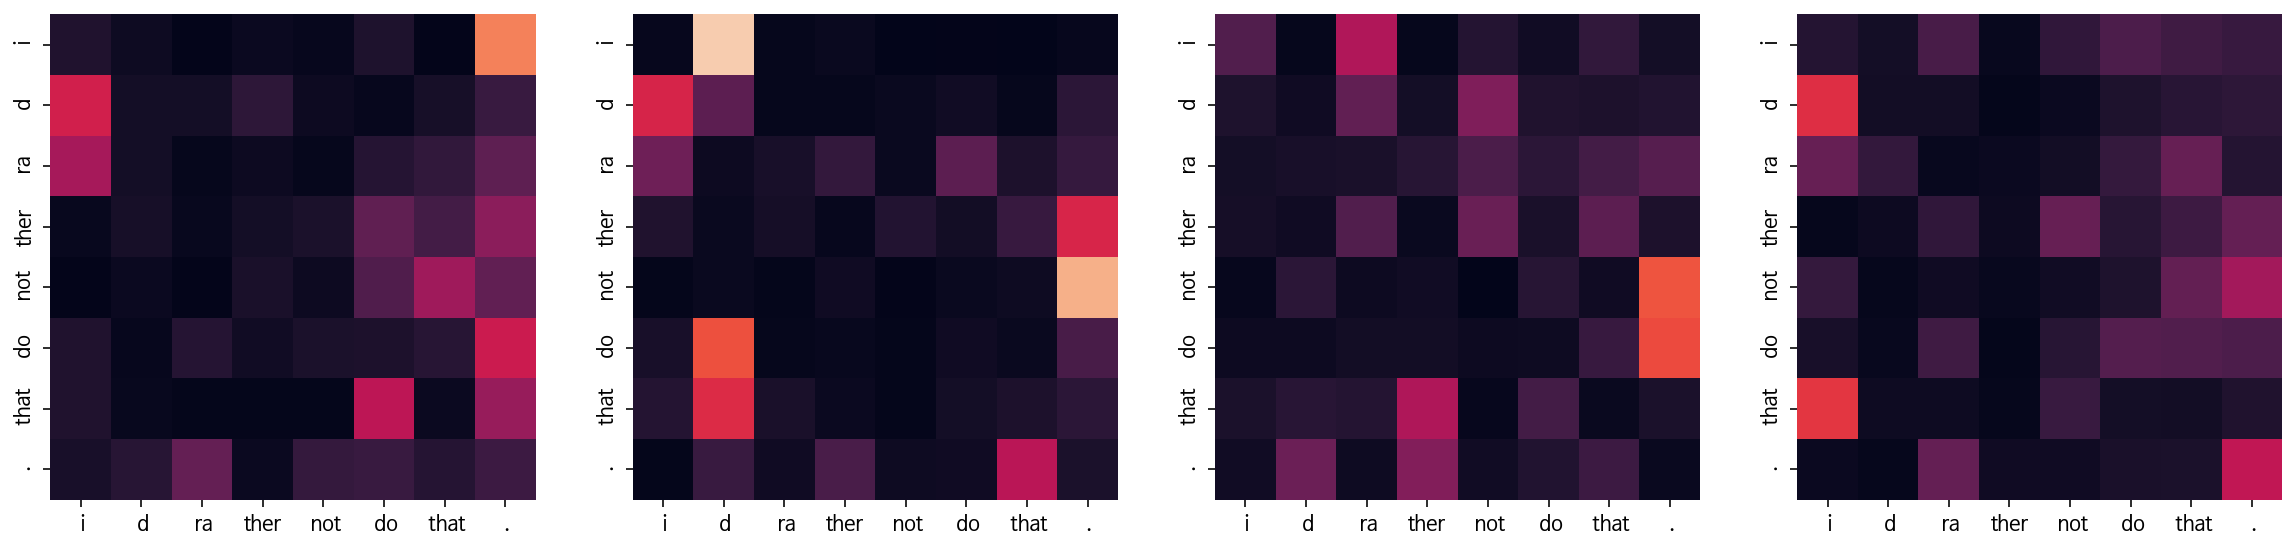

Encoder Layer 2


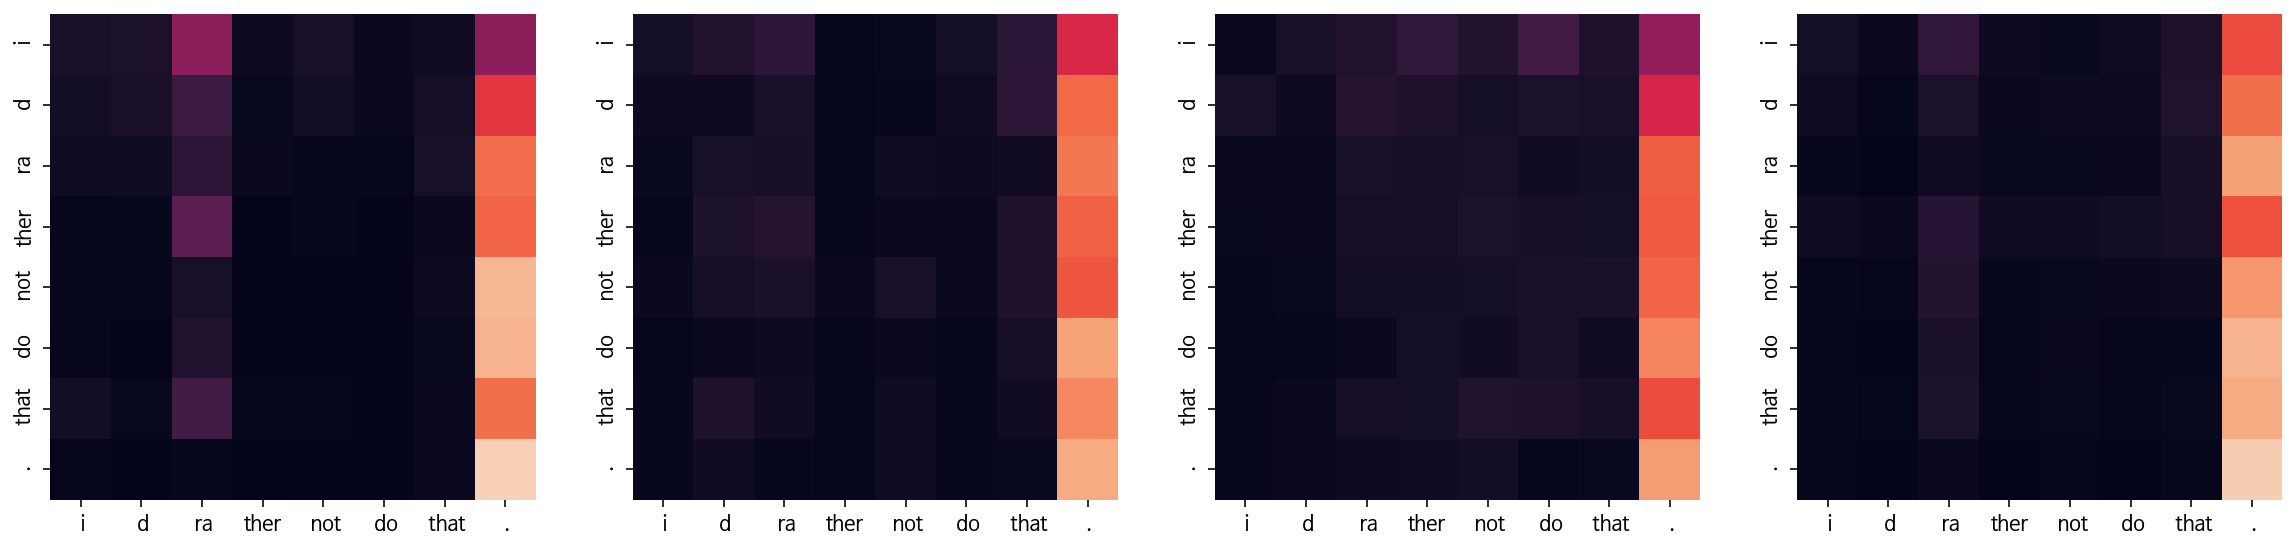

Decoder Self Layer 1


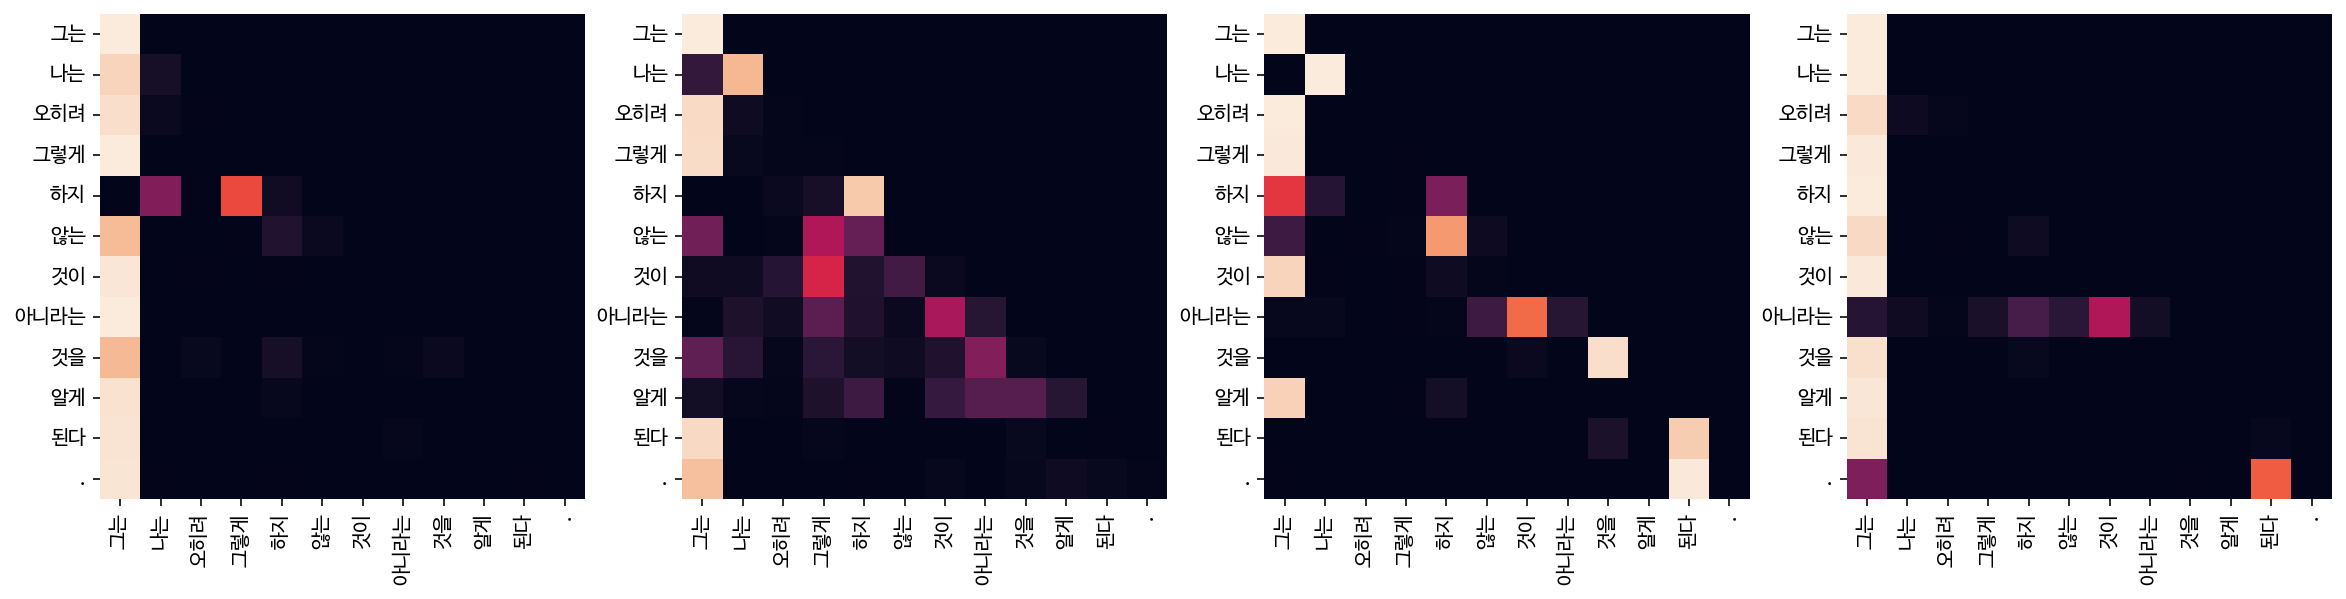

Decoder Src Layer 1


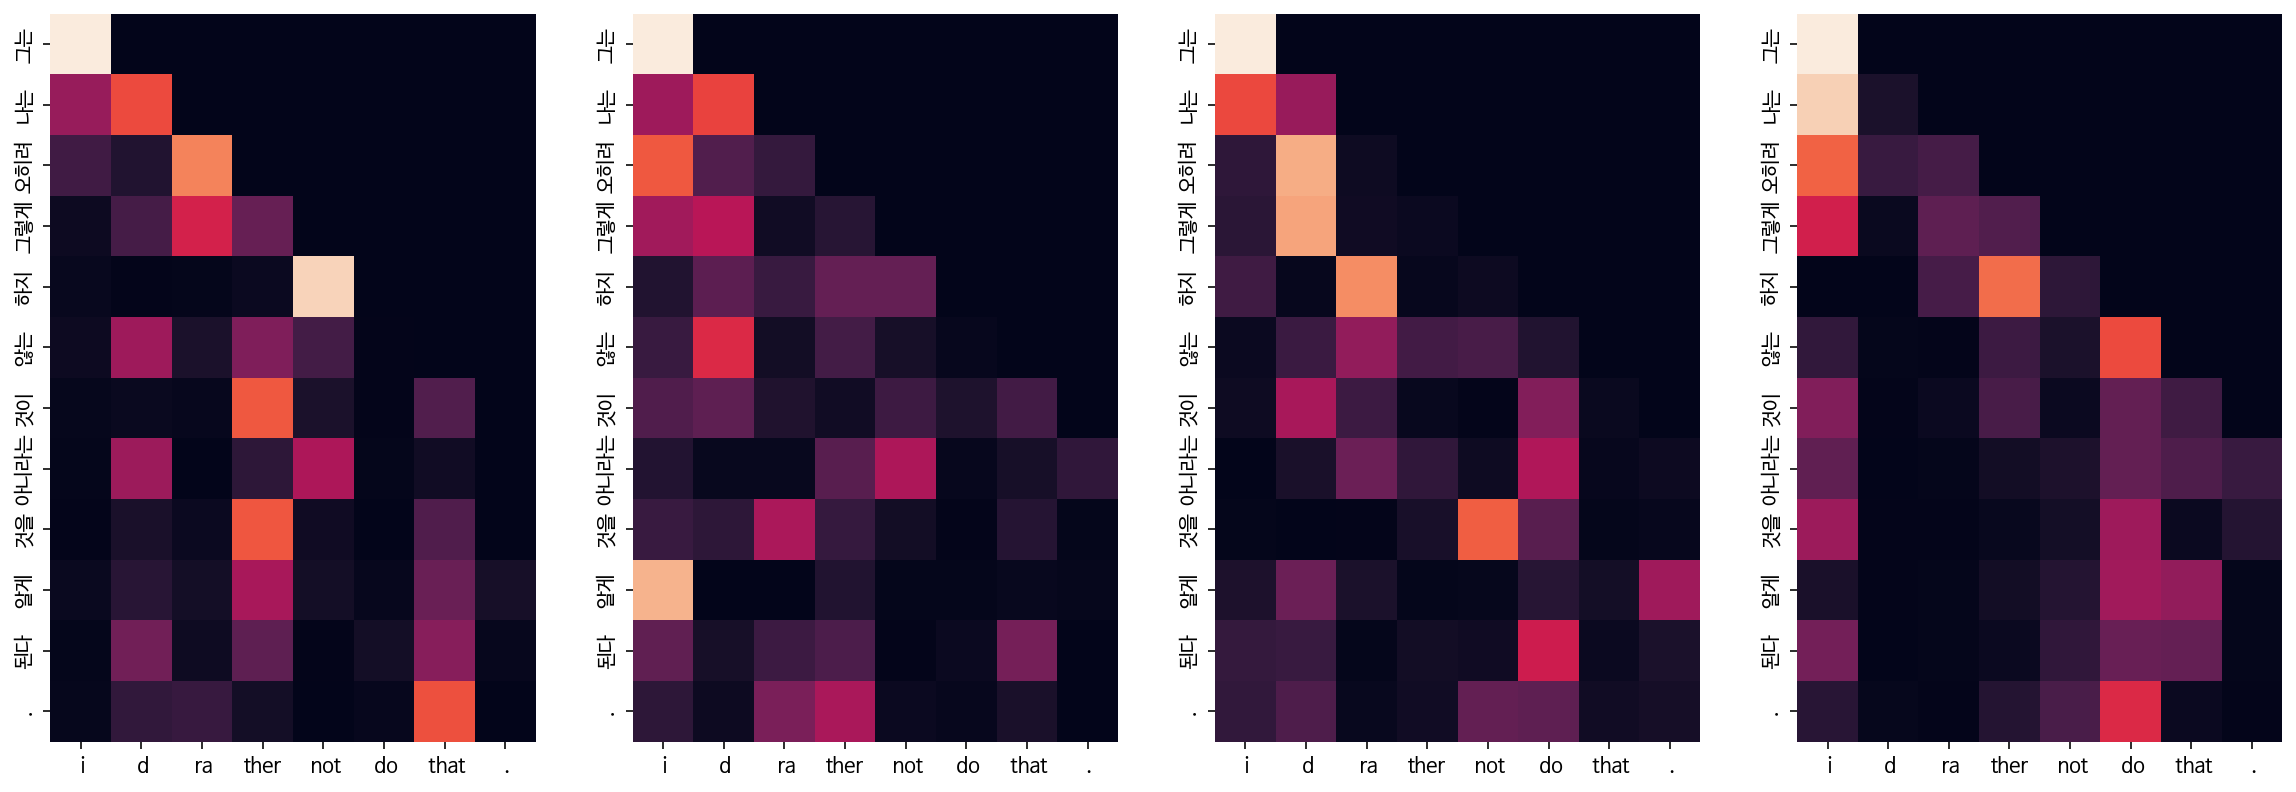

Decoder Self Layer 2


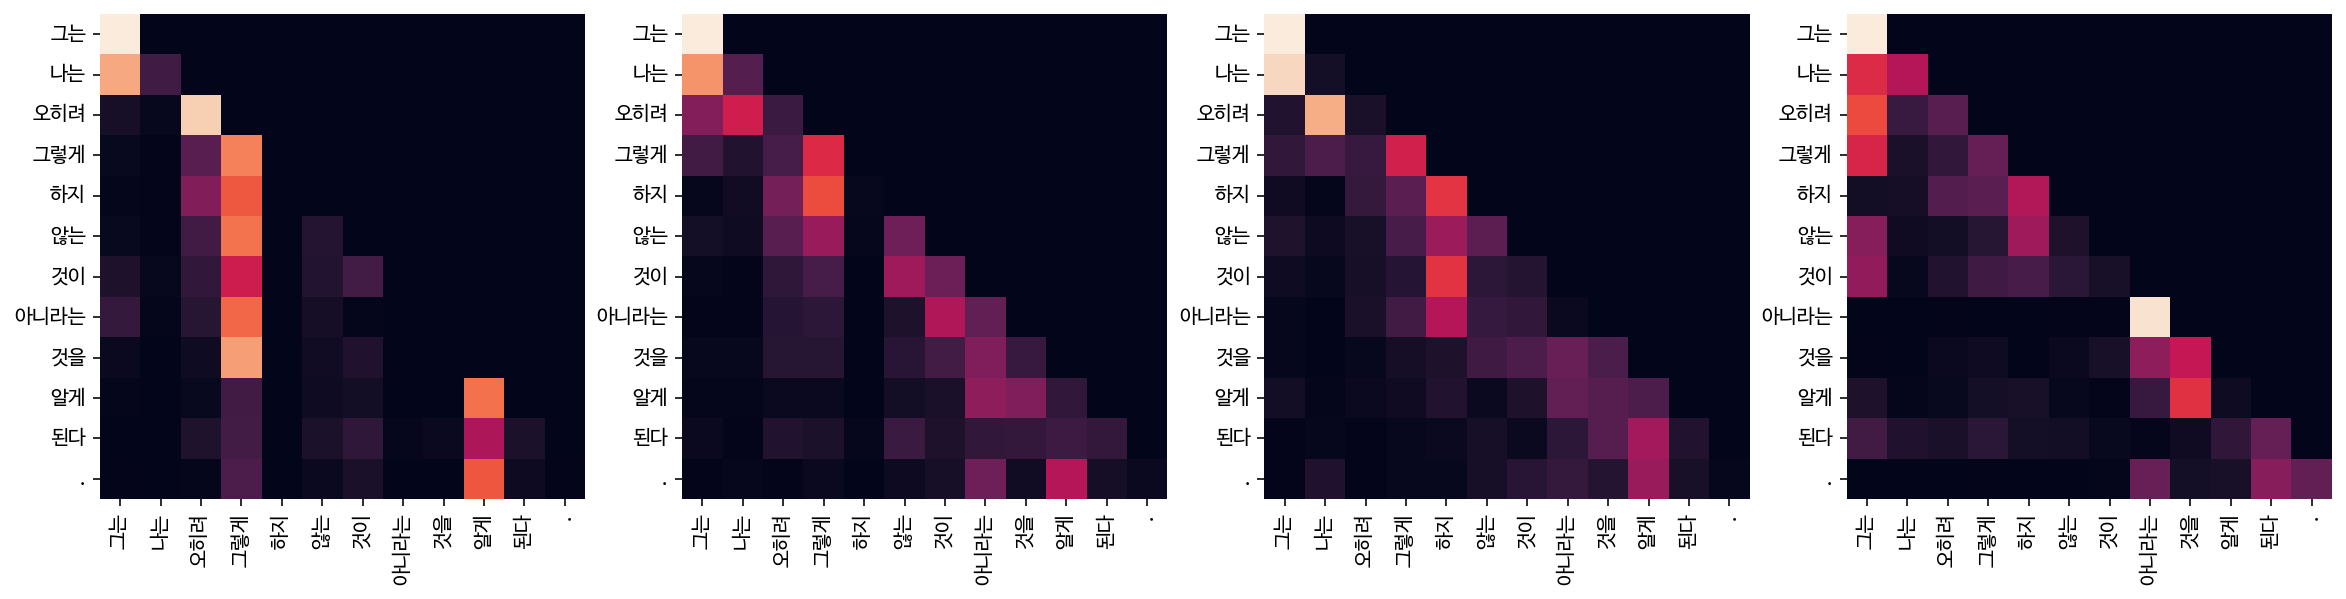

Decoder Src Layer 2


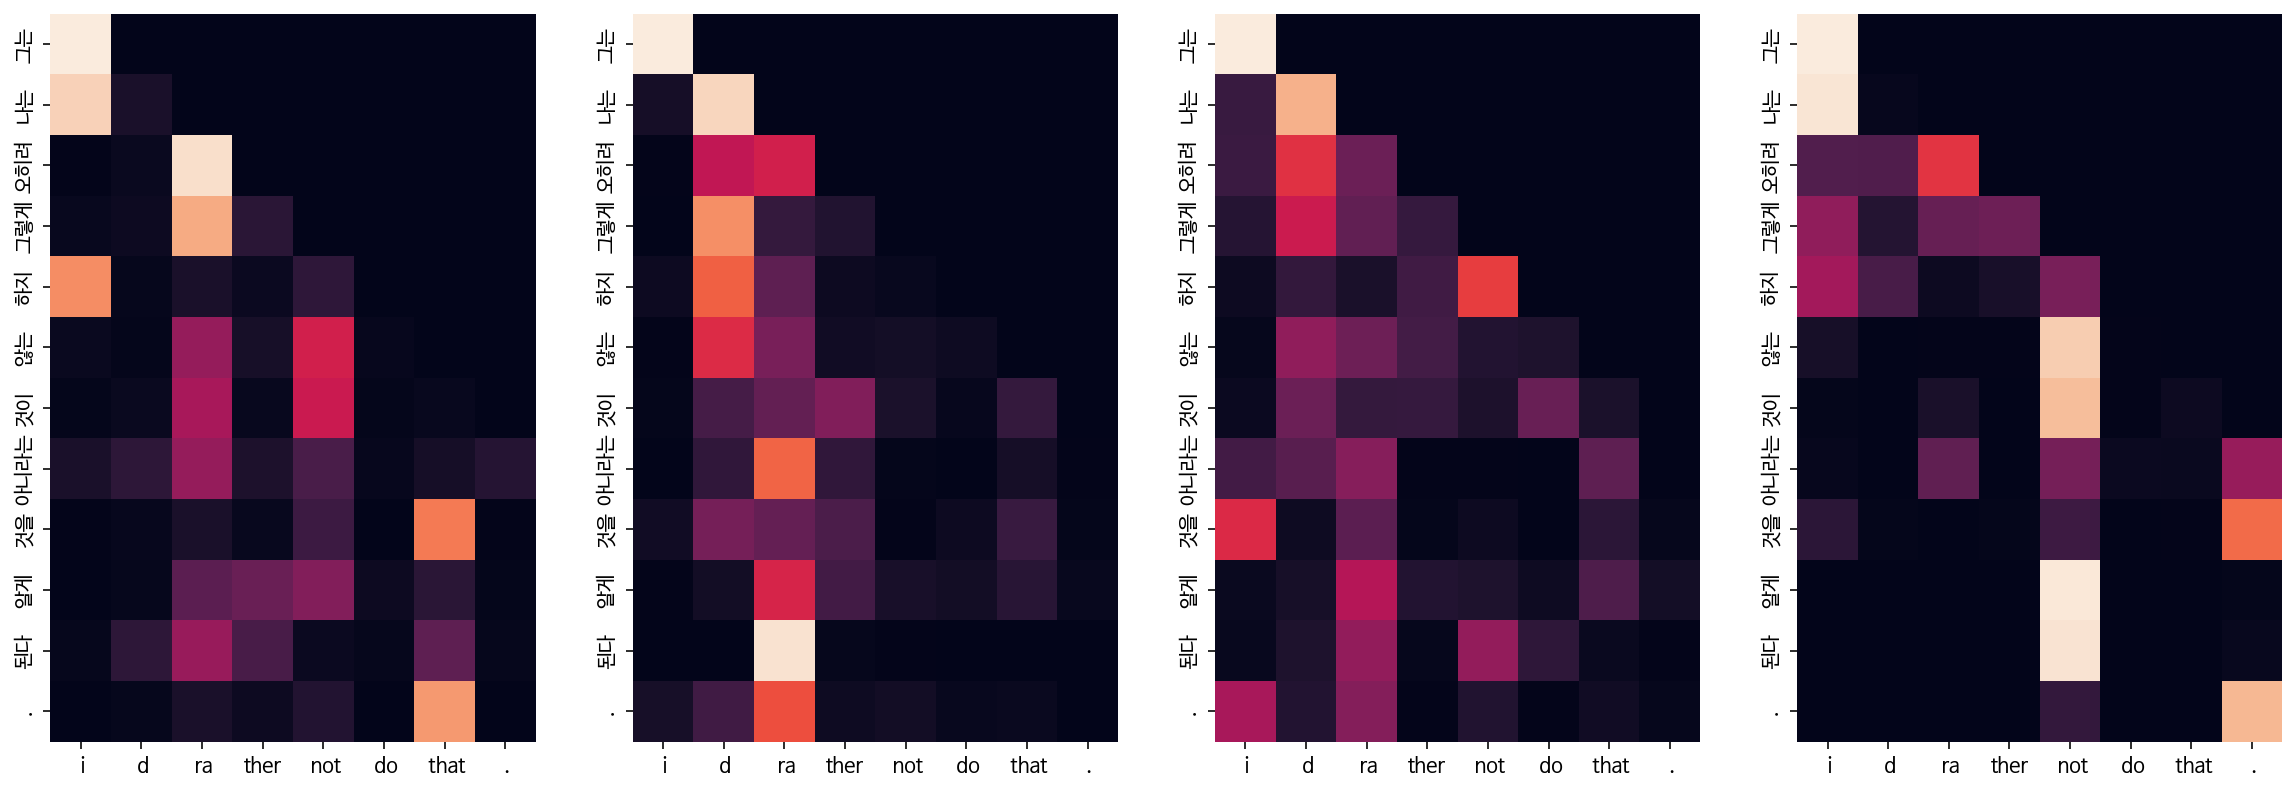

Input: You’re misunderstanding right now. Hear me out.
Predicted translation: 당신은 당신의 오해를 듣고 있습니다 .
Encoder Layer 1


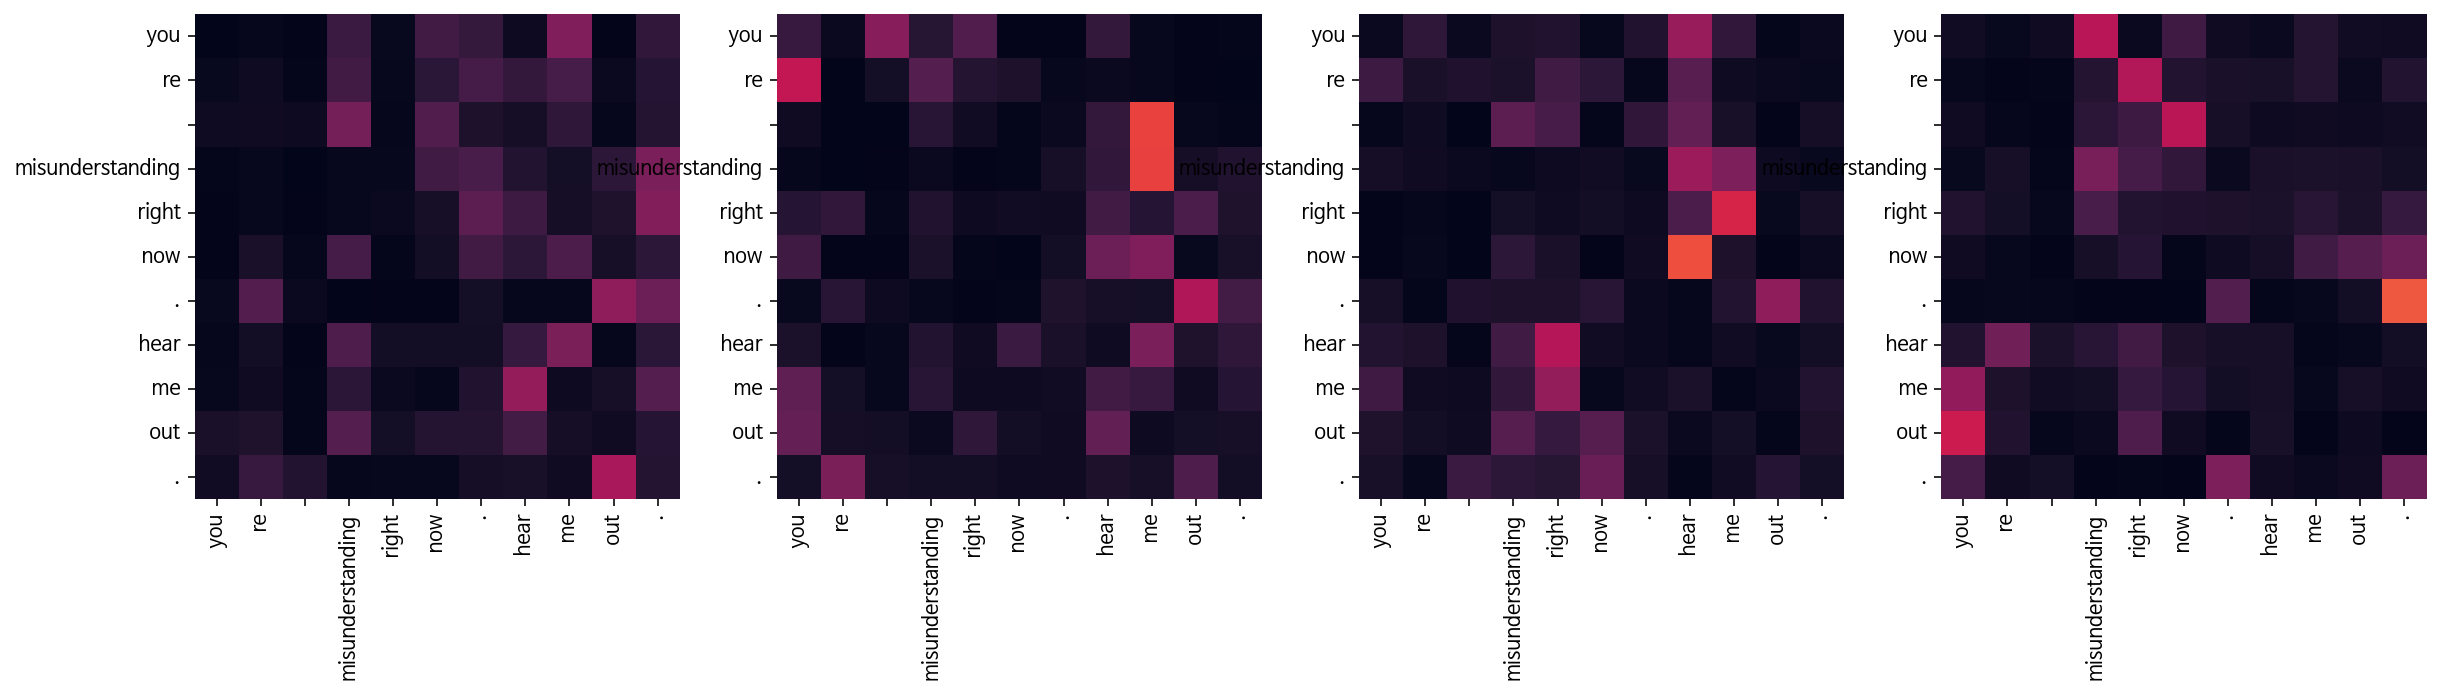

Encoder Layer 2


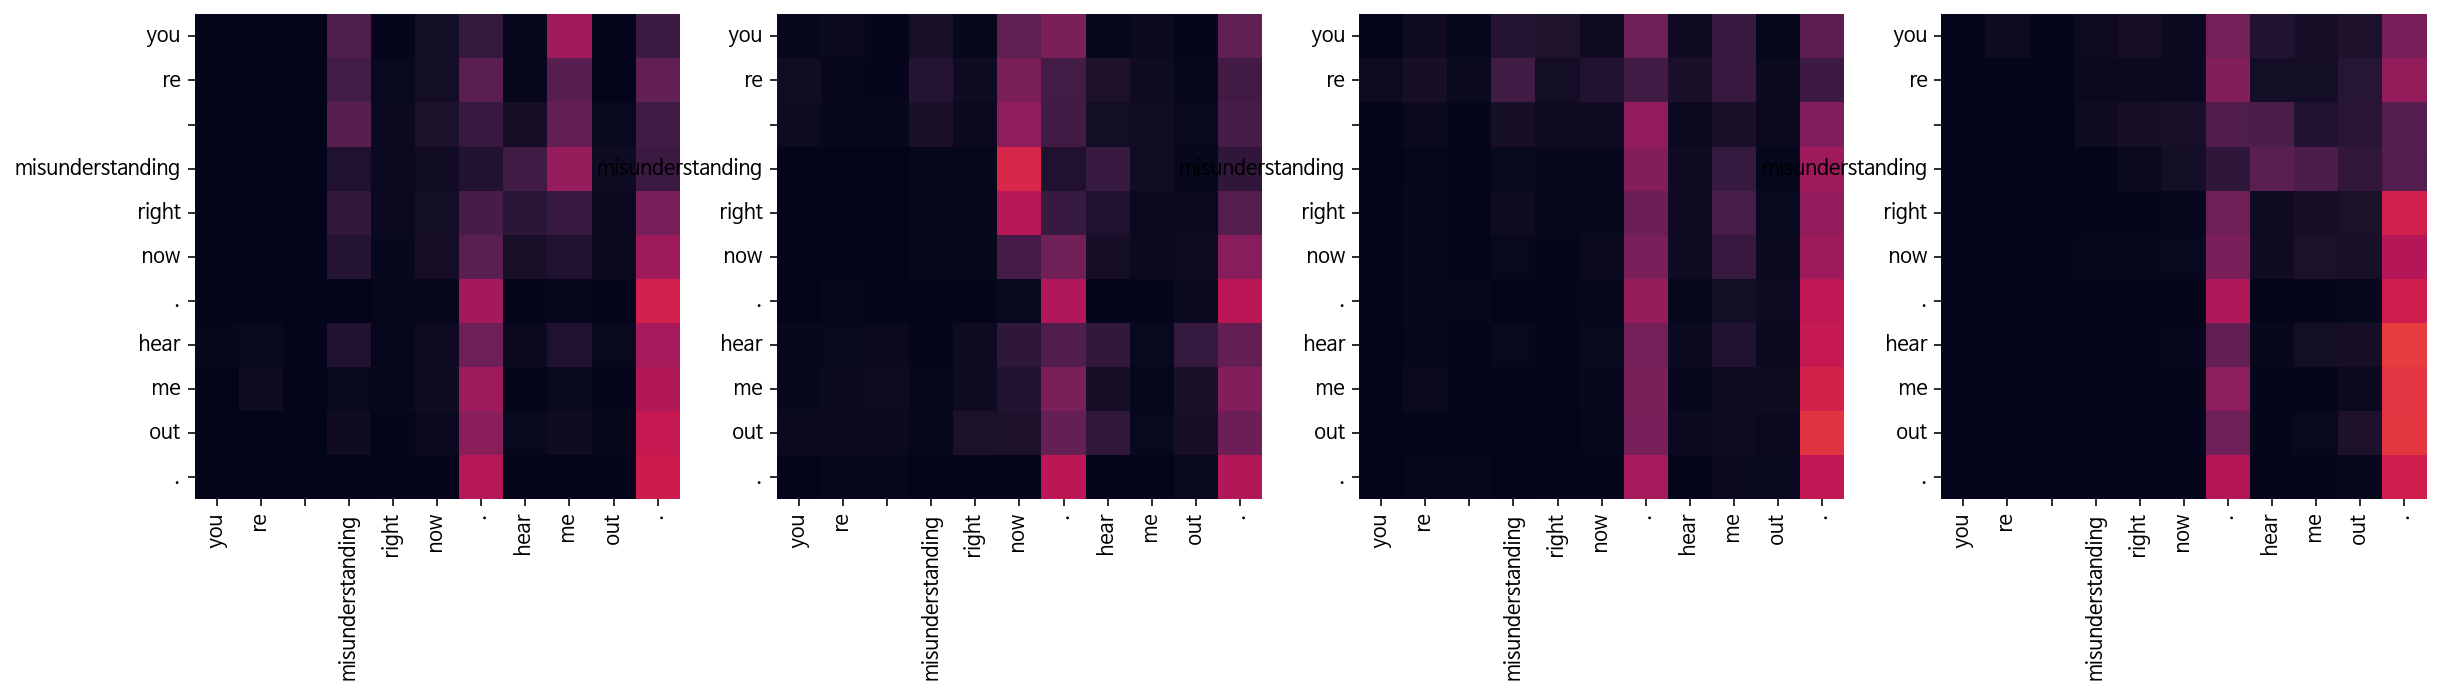

Decoder Self Layer 1


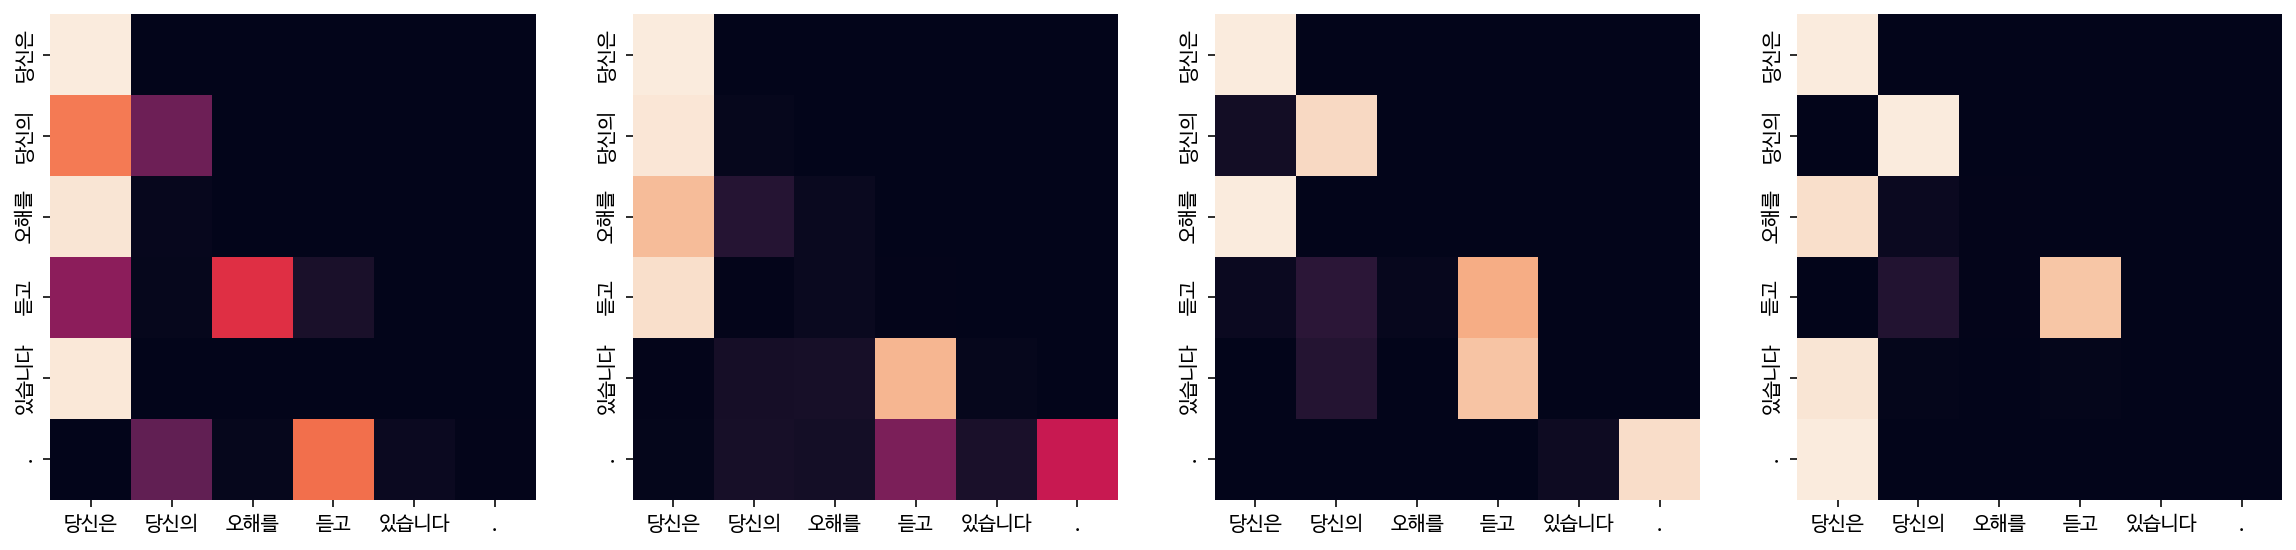

Decoder Src Layer 1


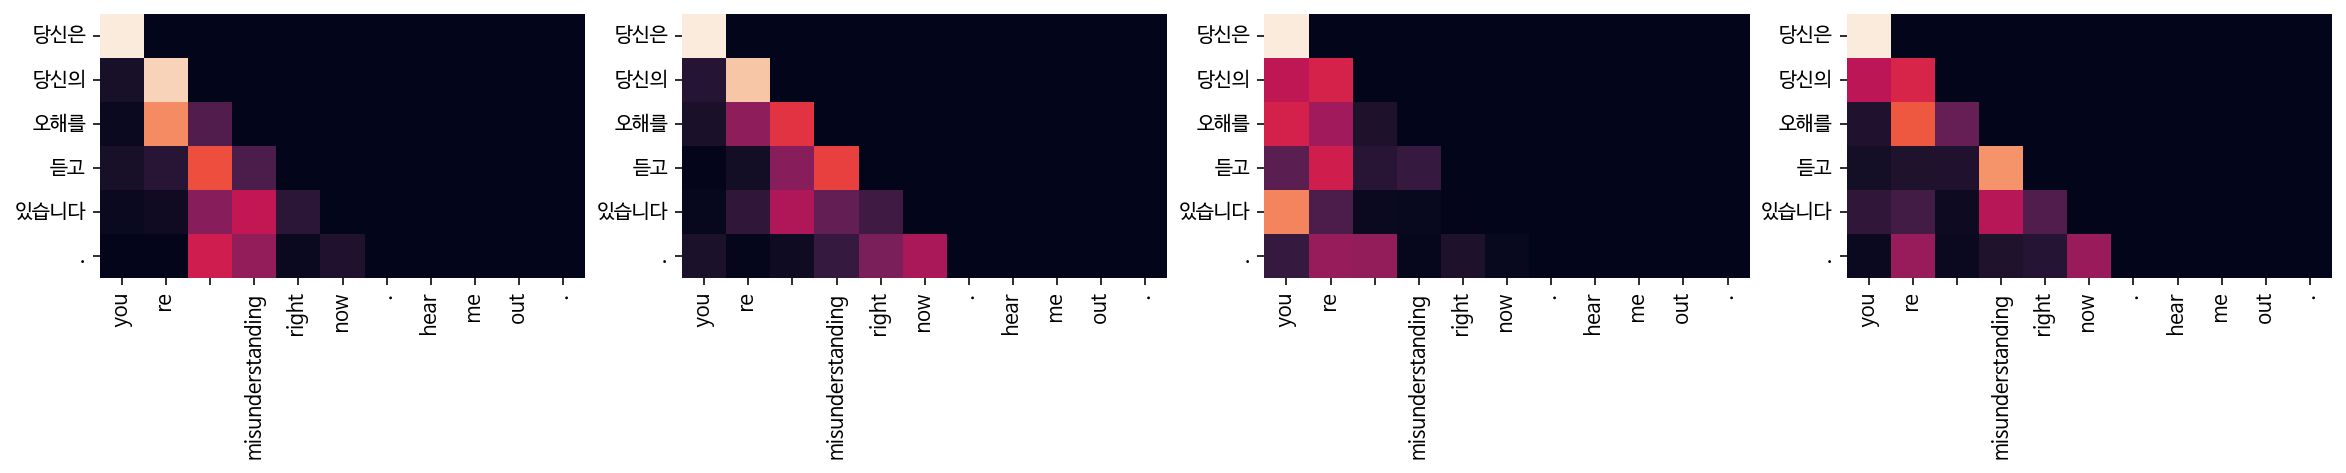

Decoder Self Layer 2


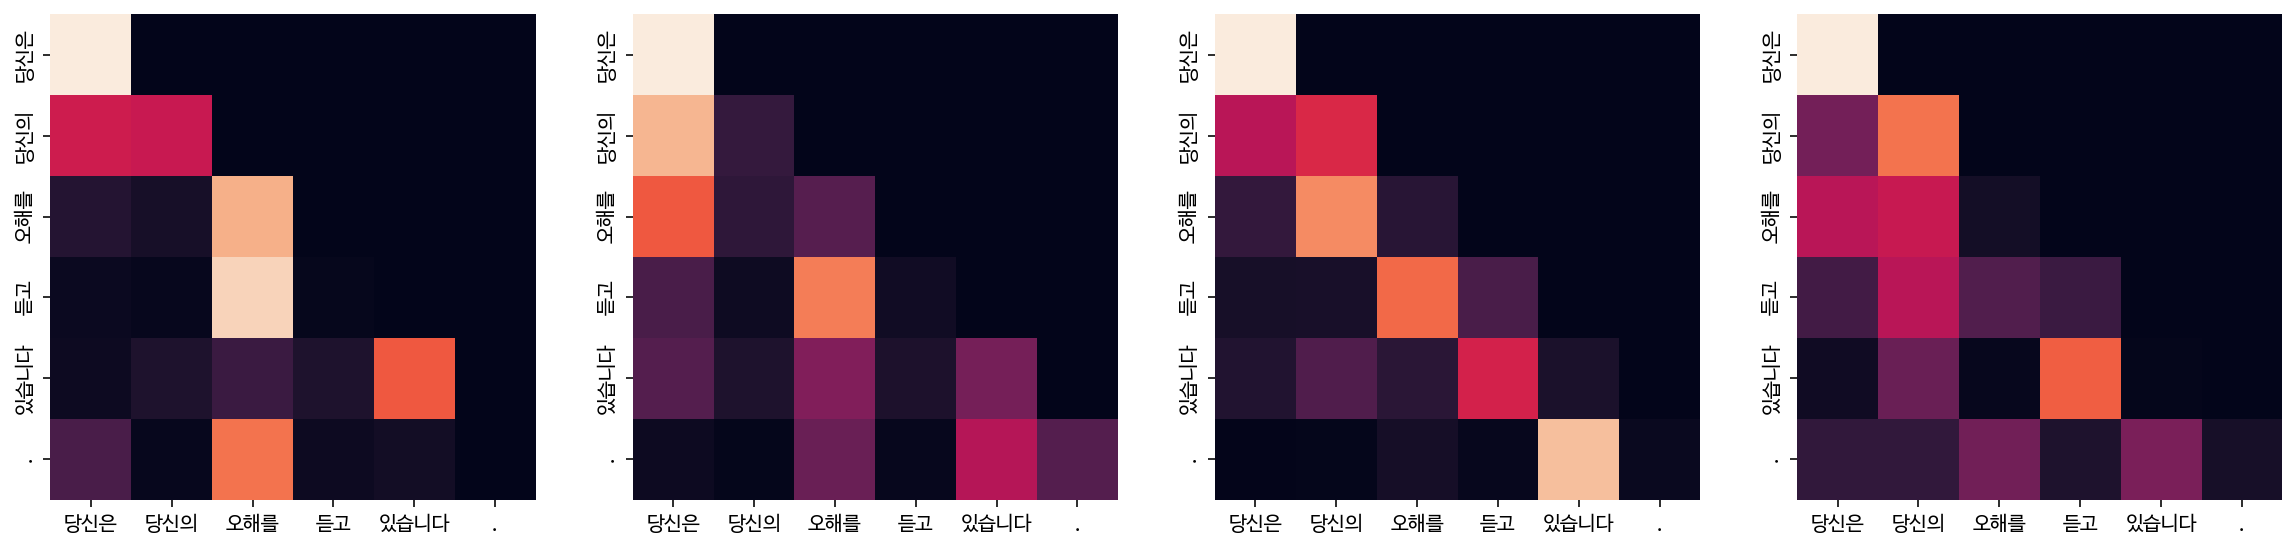

Decoder Src Layer 2


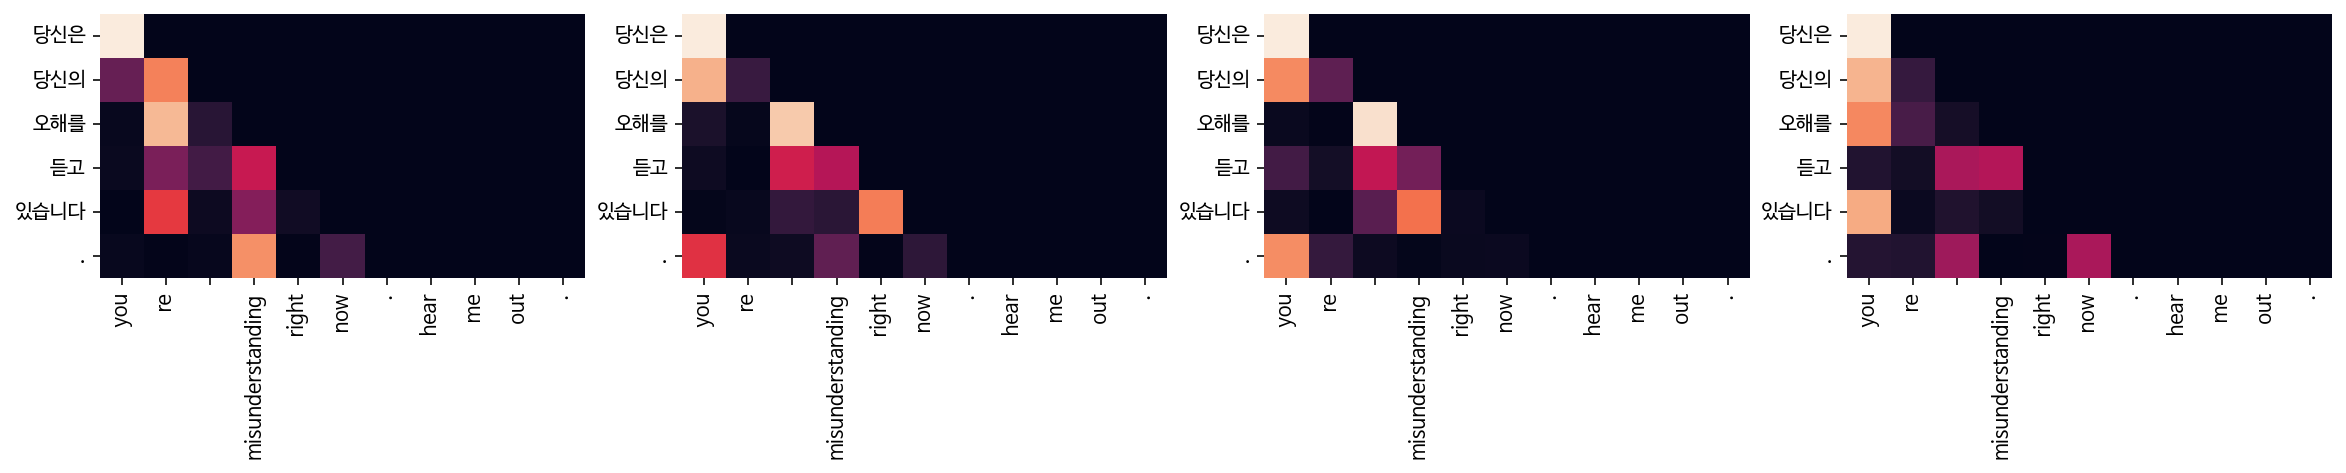

Input: I’m in good shape.
Predicted translation: 좋은 경험이 되는 상태다 .
Encoder Layer 1


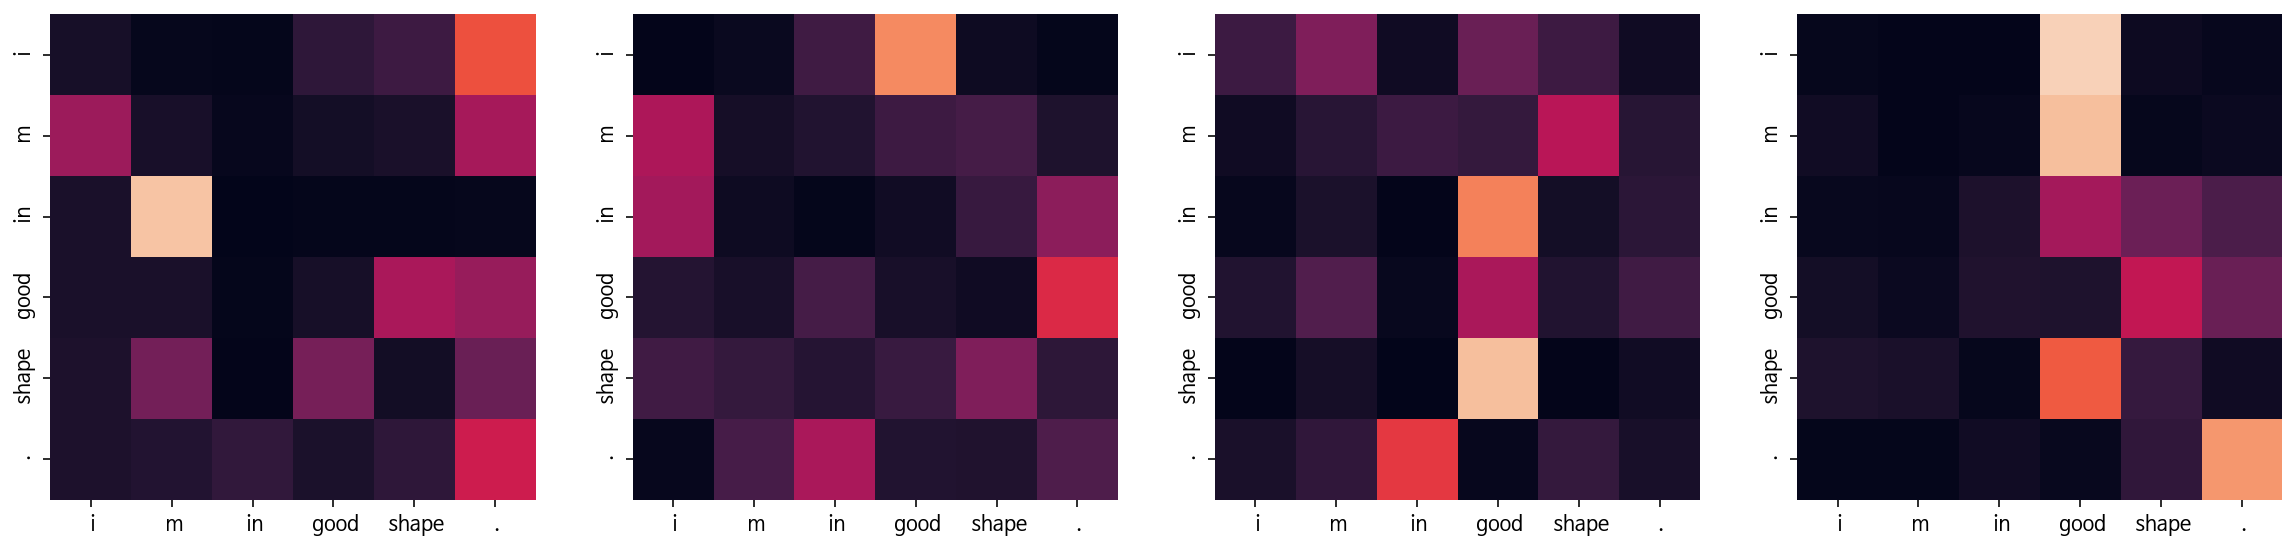

Encoder Layer 2


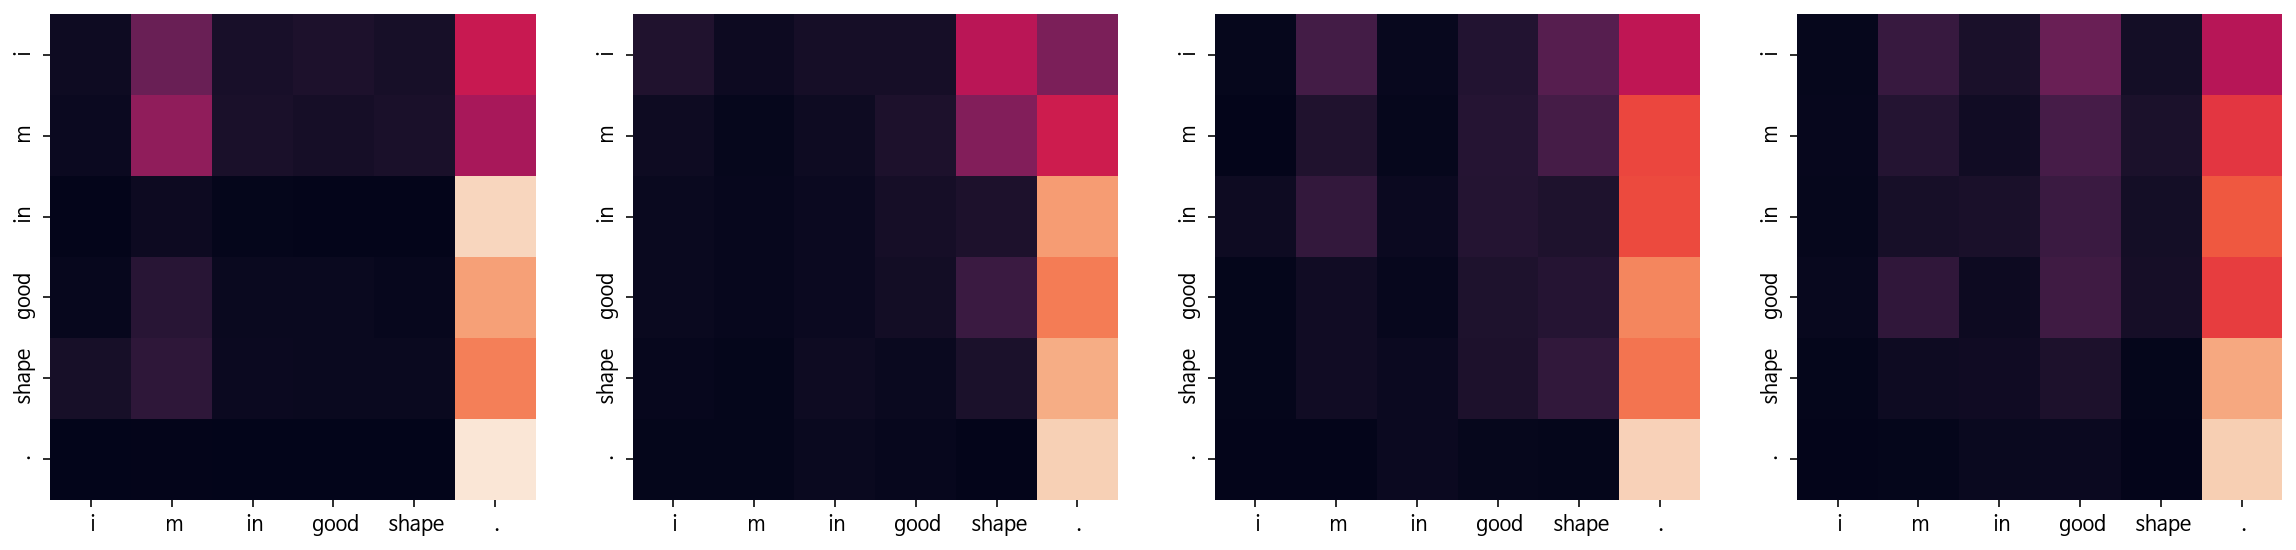

Decoder Self Layer 1


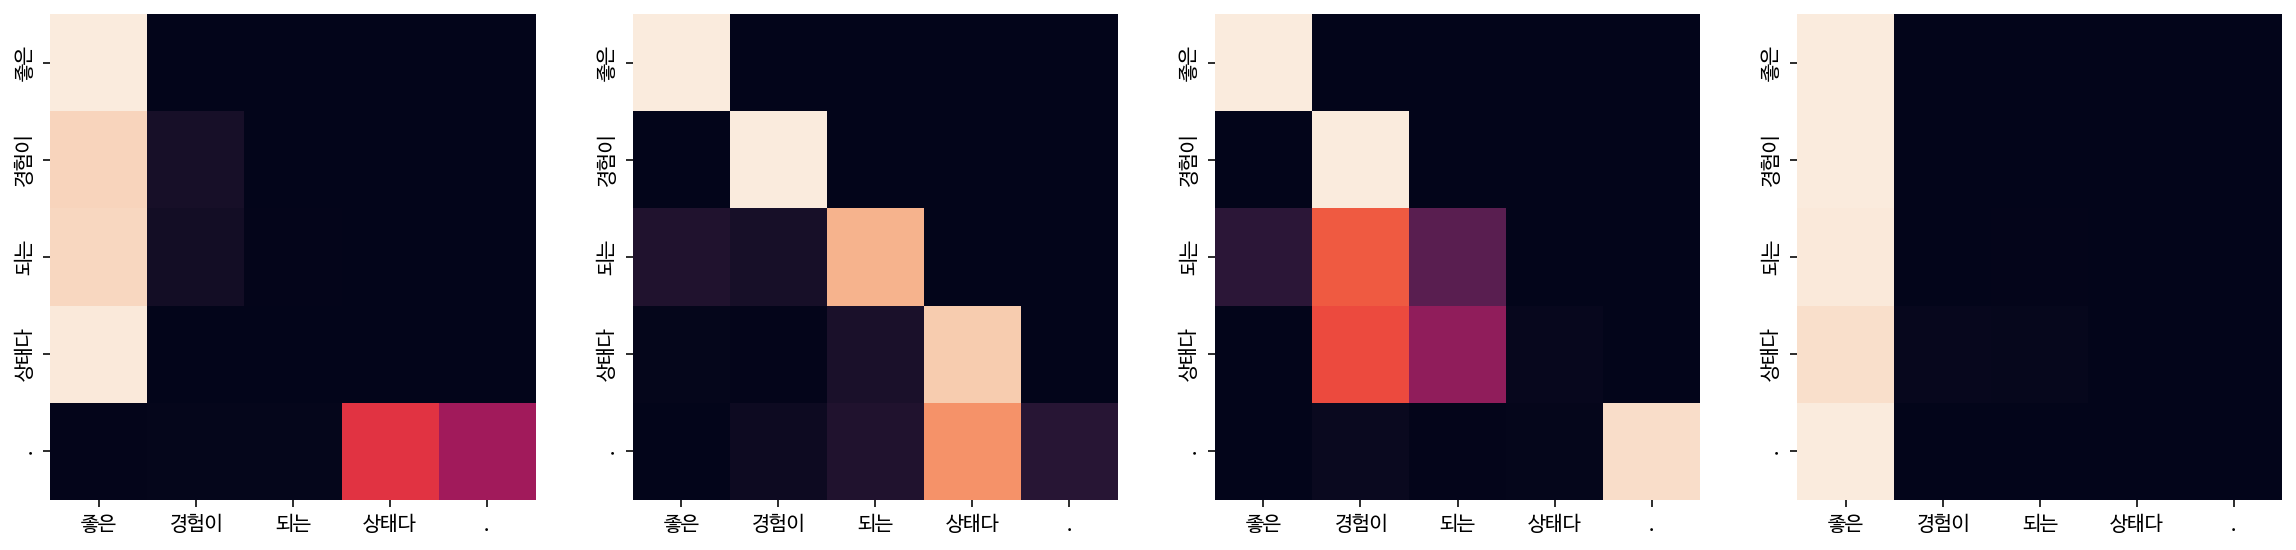

Decoder Src Layer 1


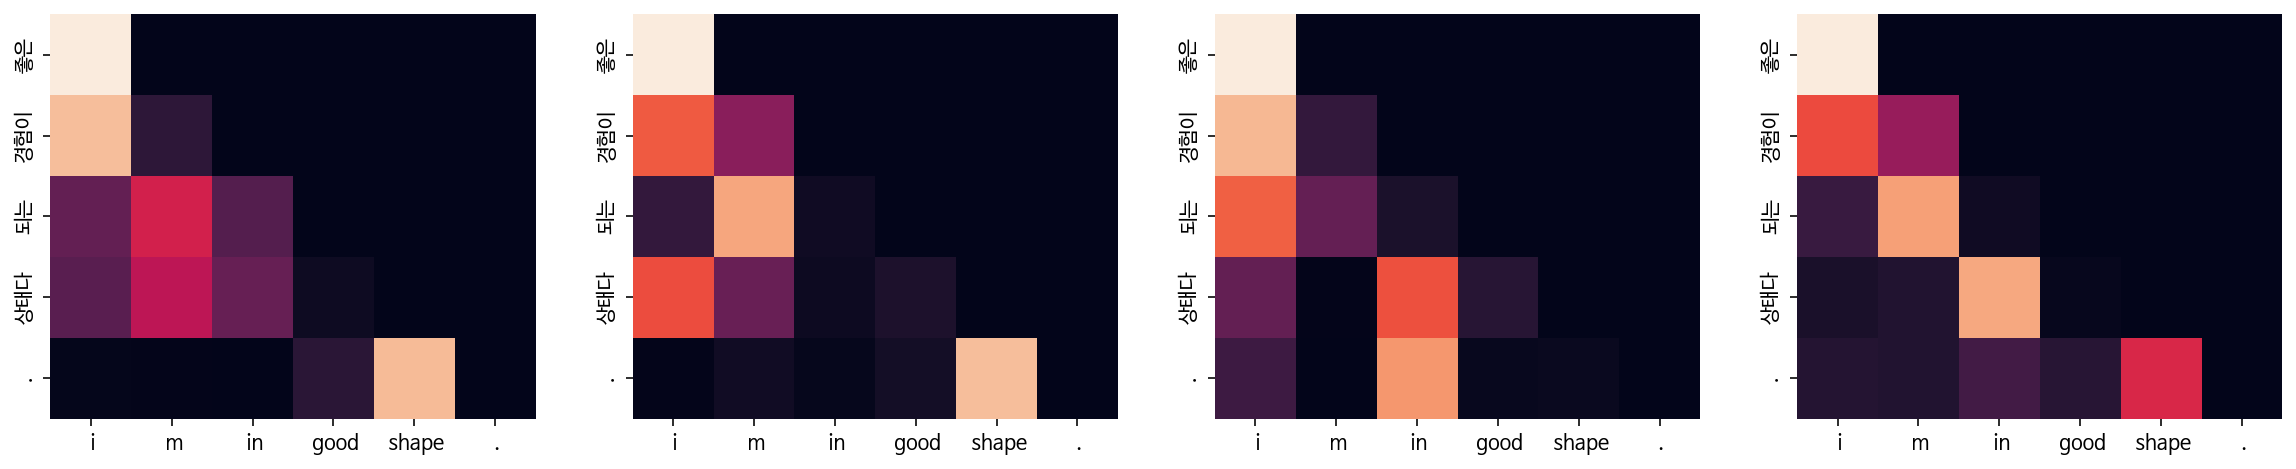

Decoder Self Layer 2


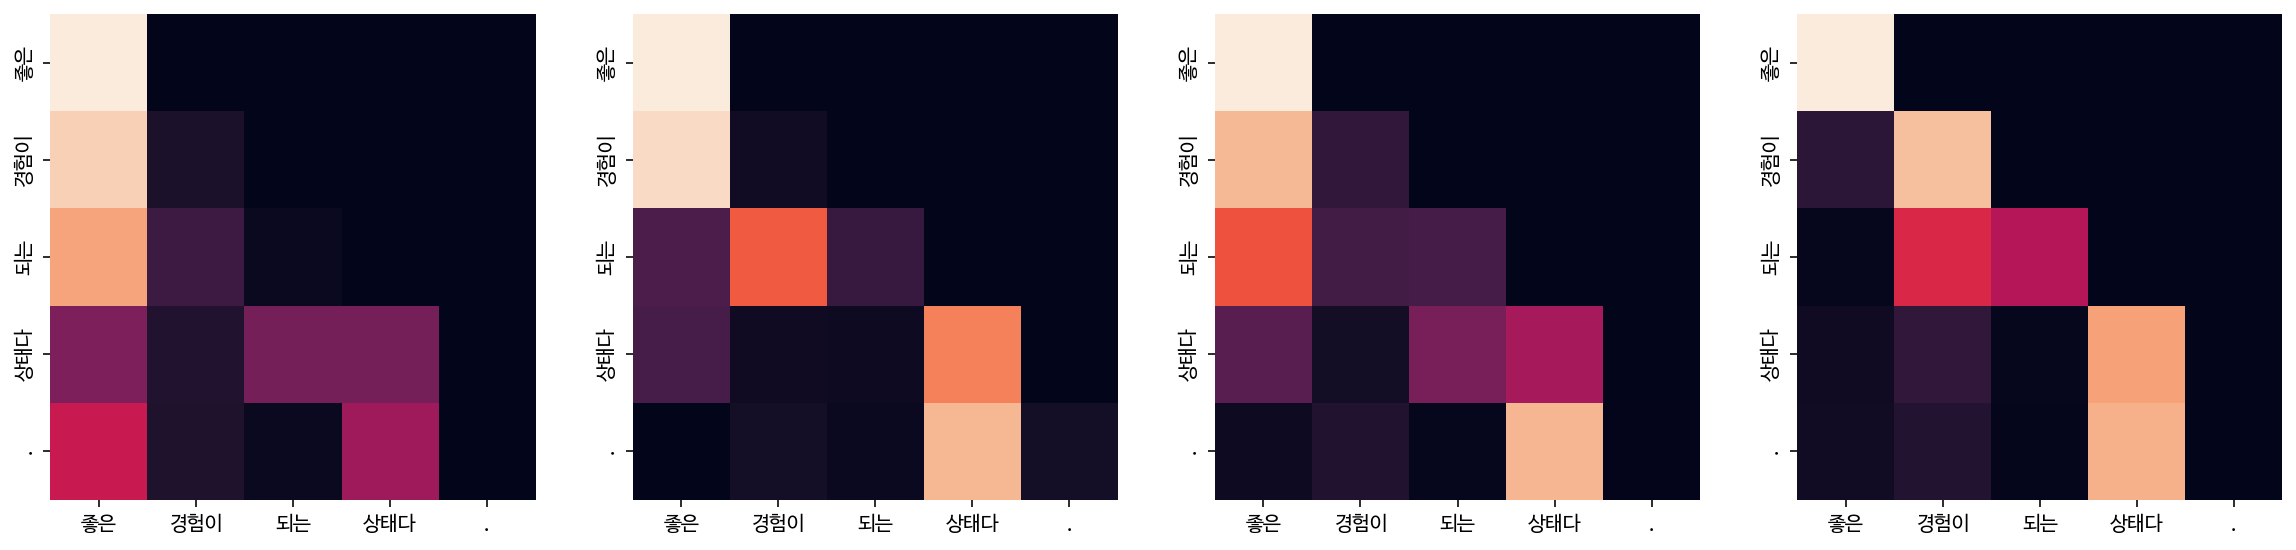

Decoder Src Layer 2


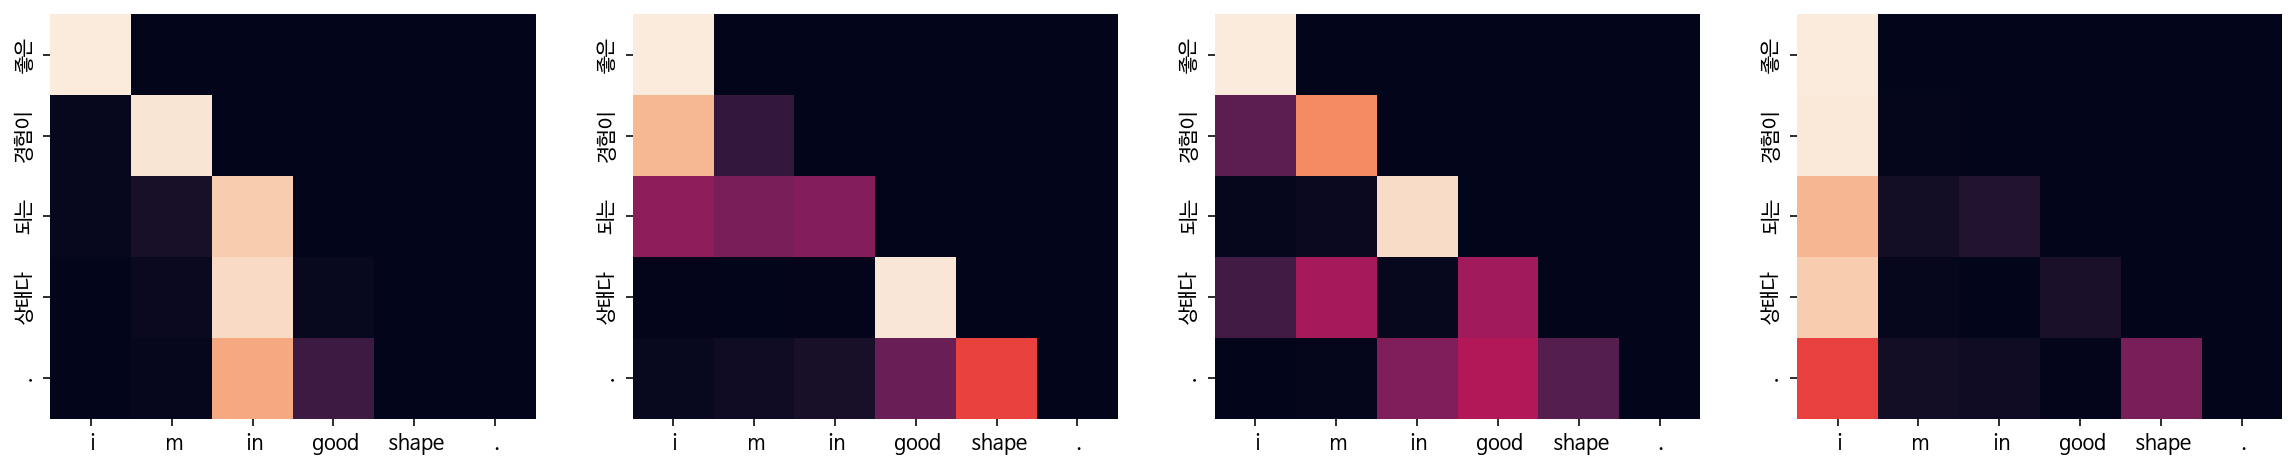

Input: Would you like to have some coffee?
Predicted translation: 일부 커피를 타고 저렴하게 커피를 지불하게 될 것인가 ?
Encoder Layer 1


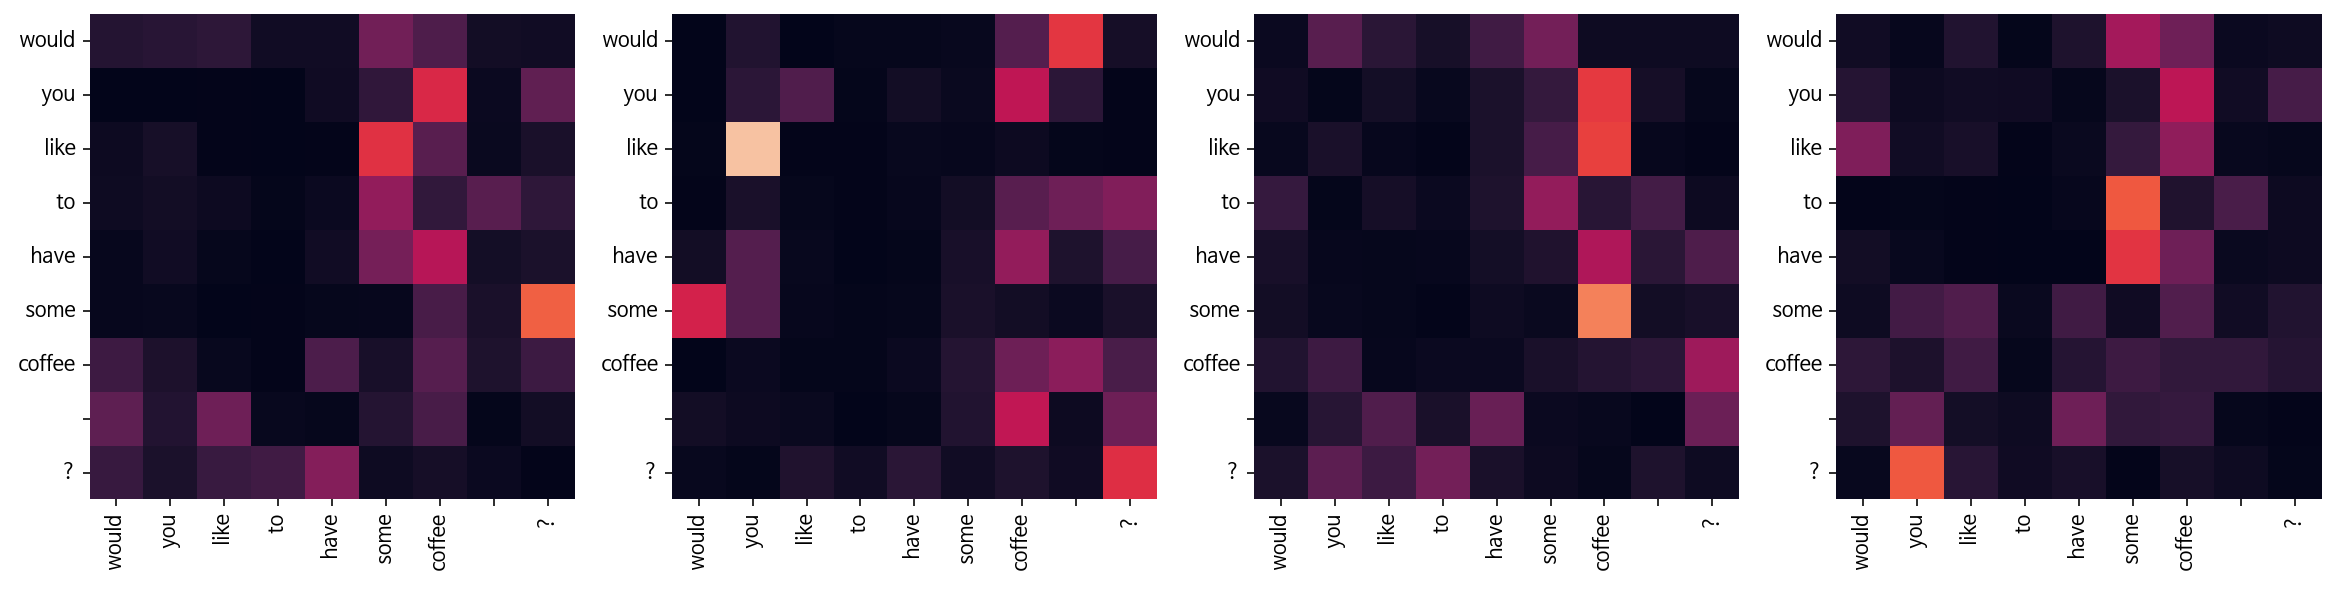

Encoder Layer 2


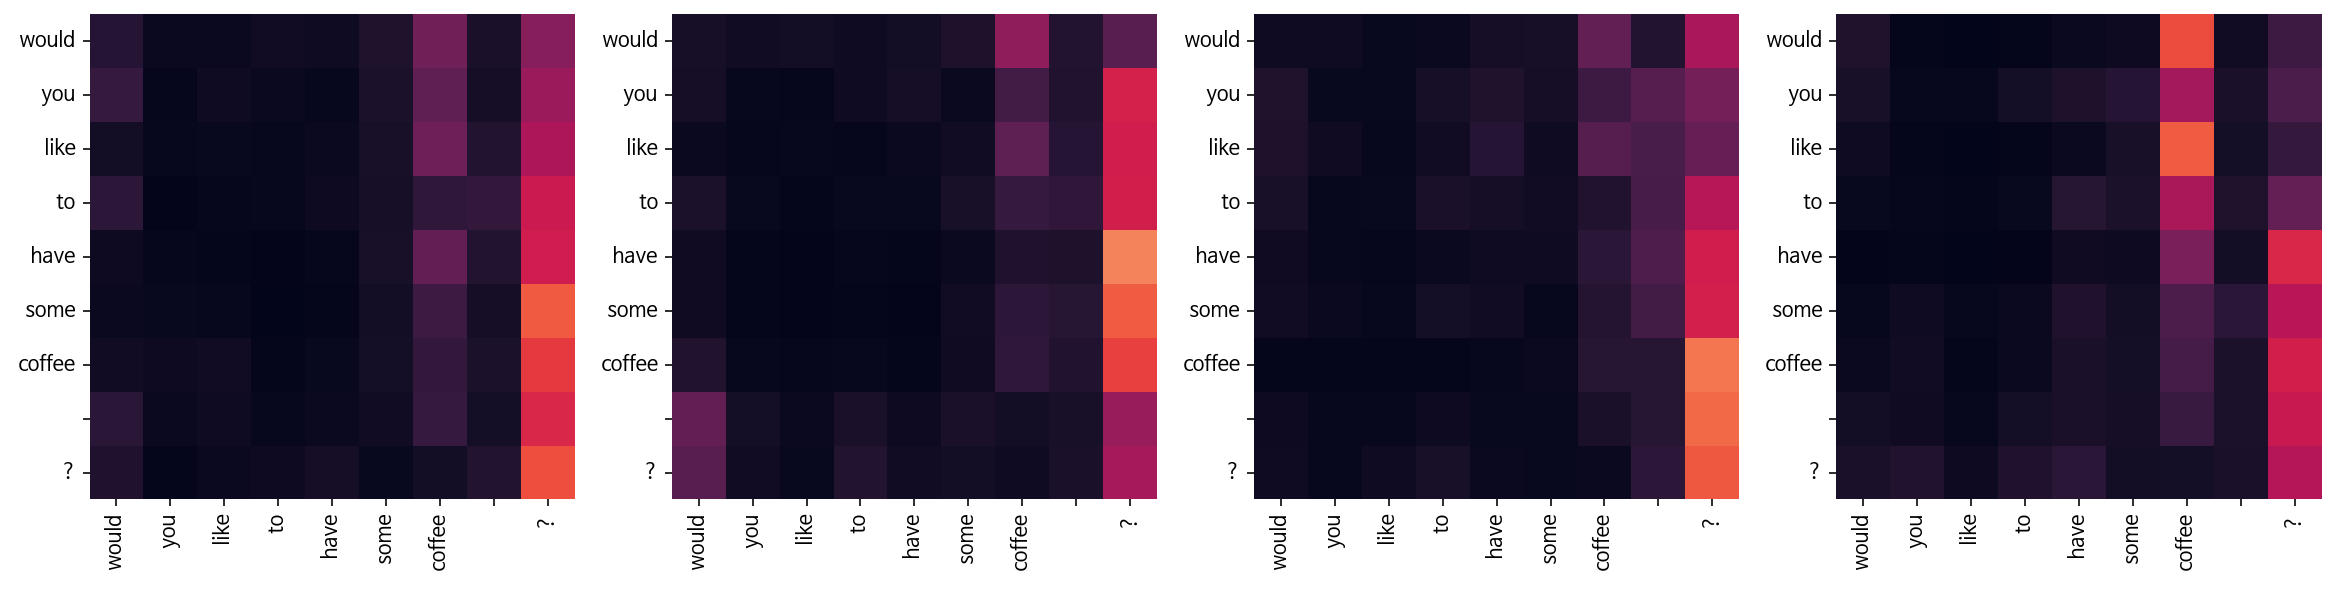

Decoder Self Layer 1


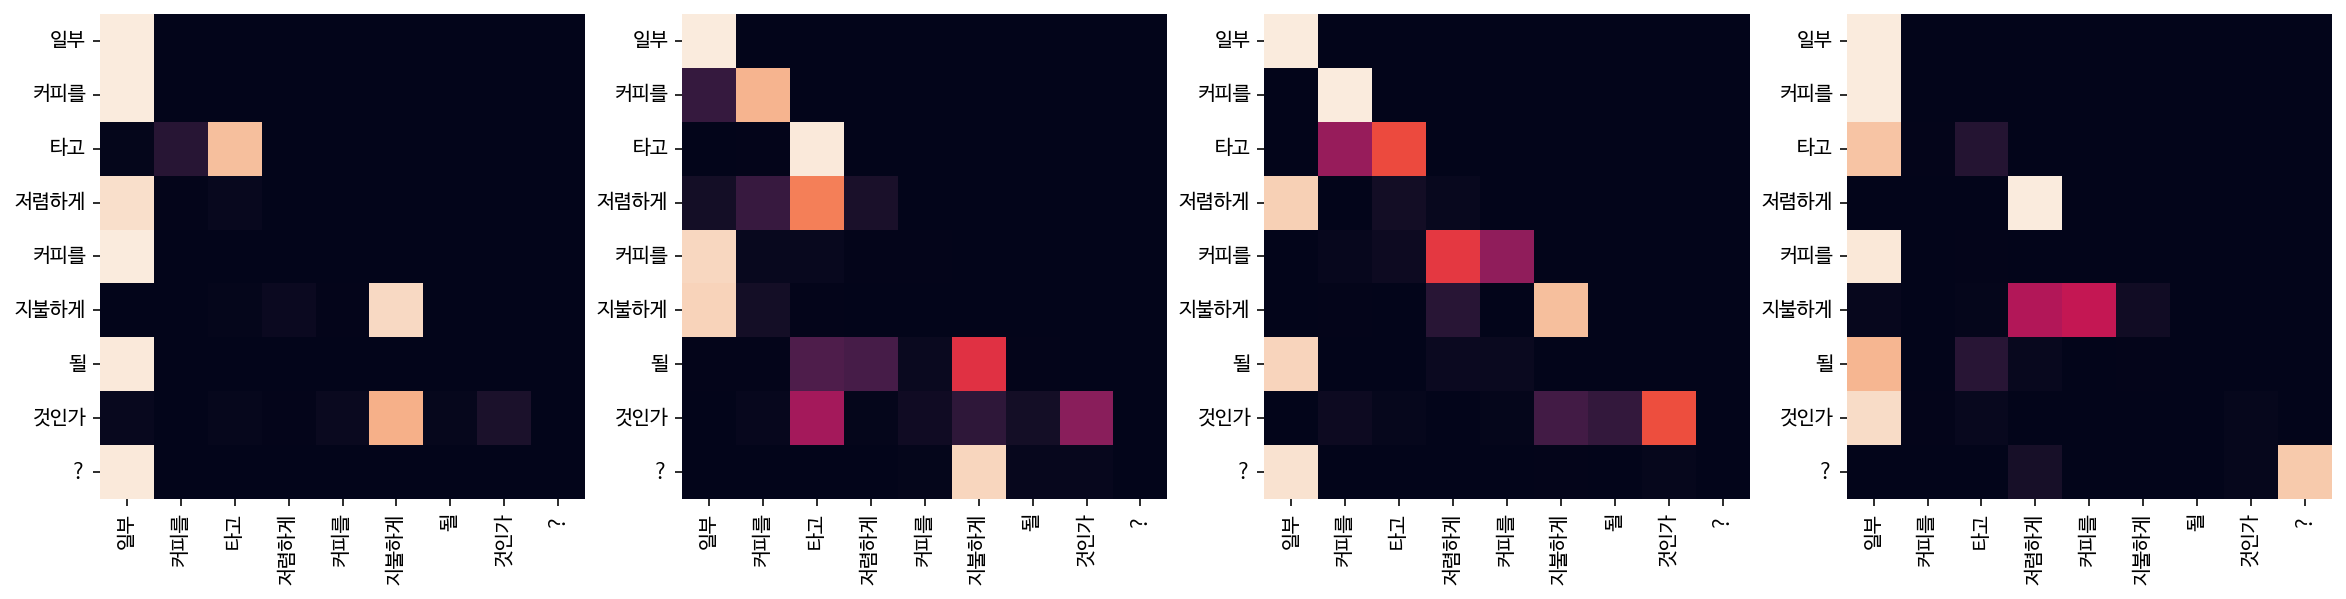

Decoder Src Layer 1


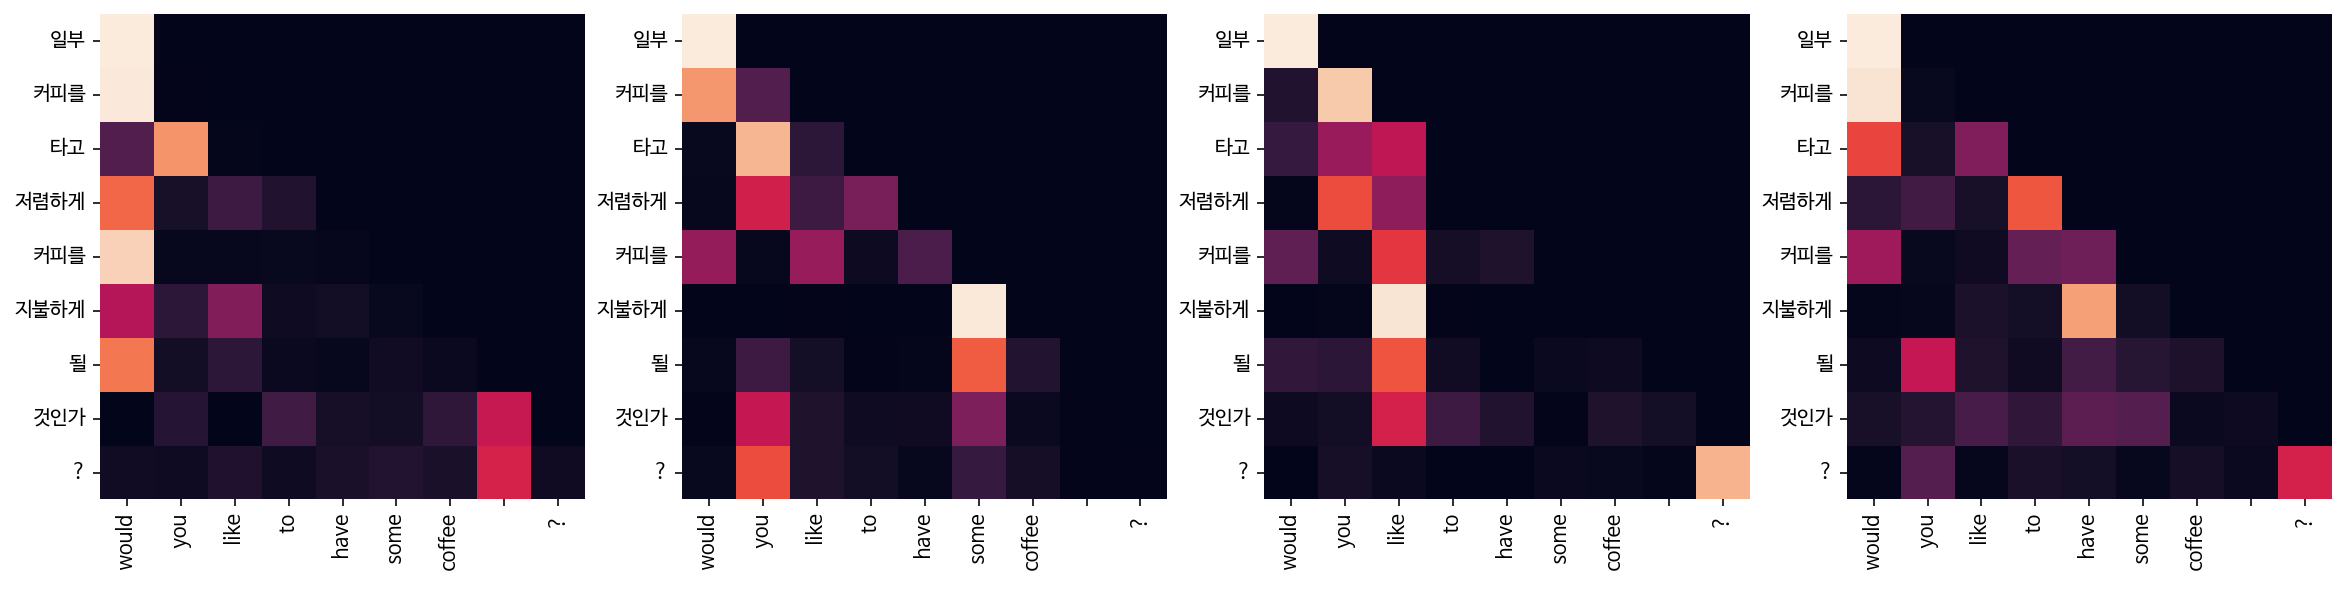

Decoder Self Layer 2


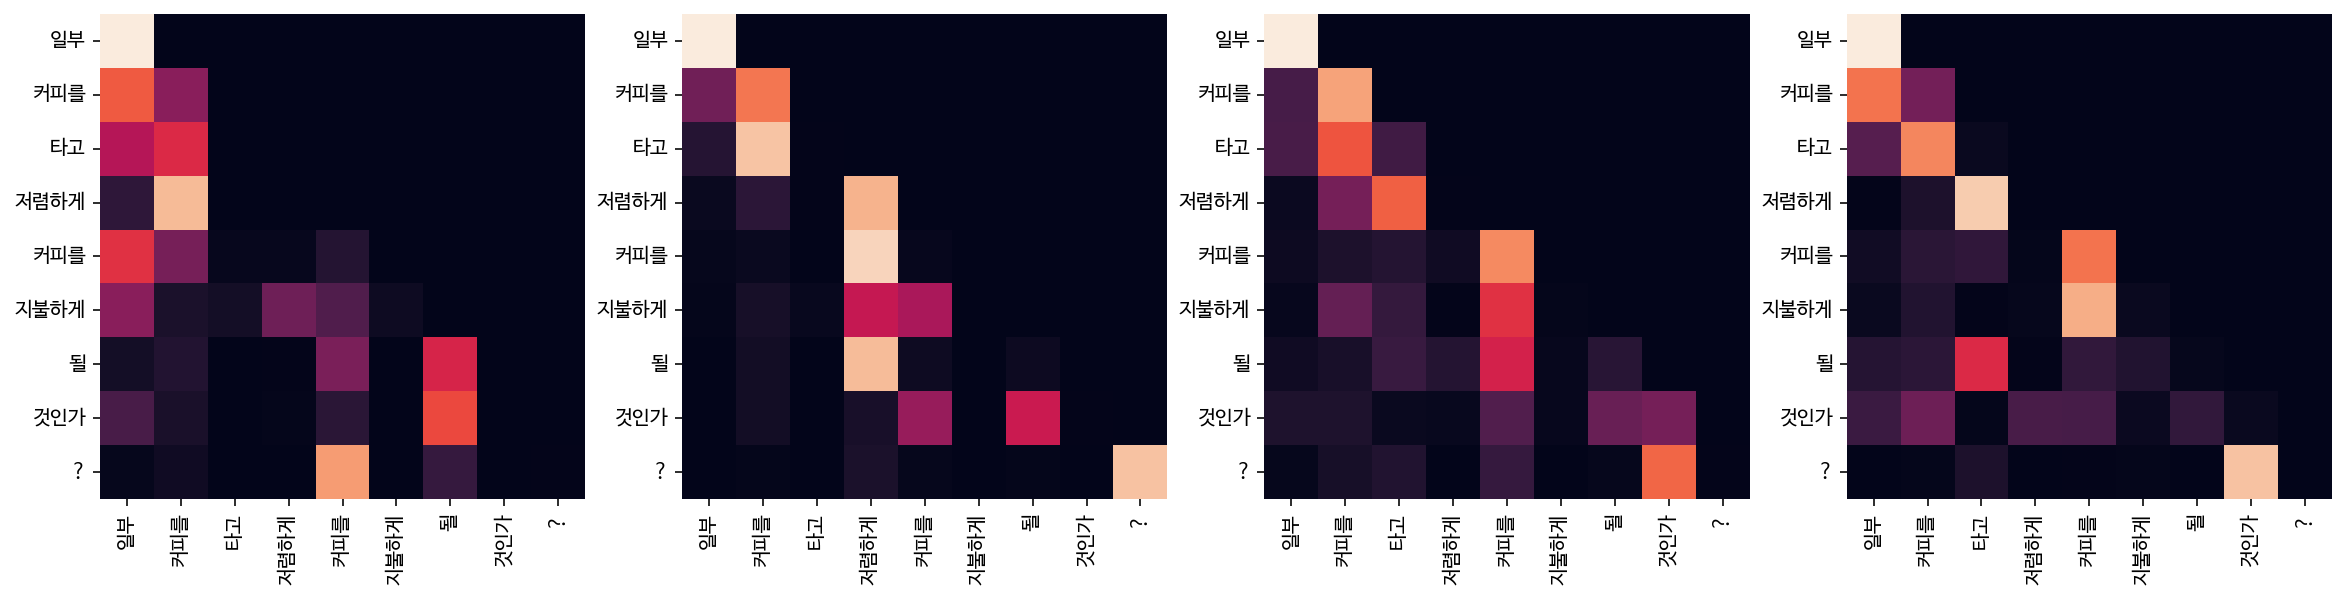

Decoder Src Layer 2


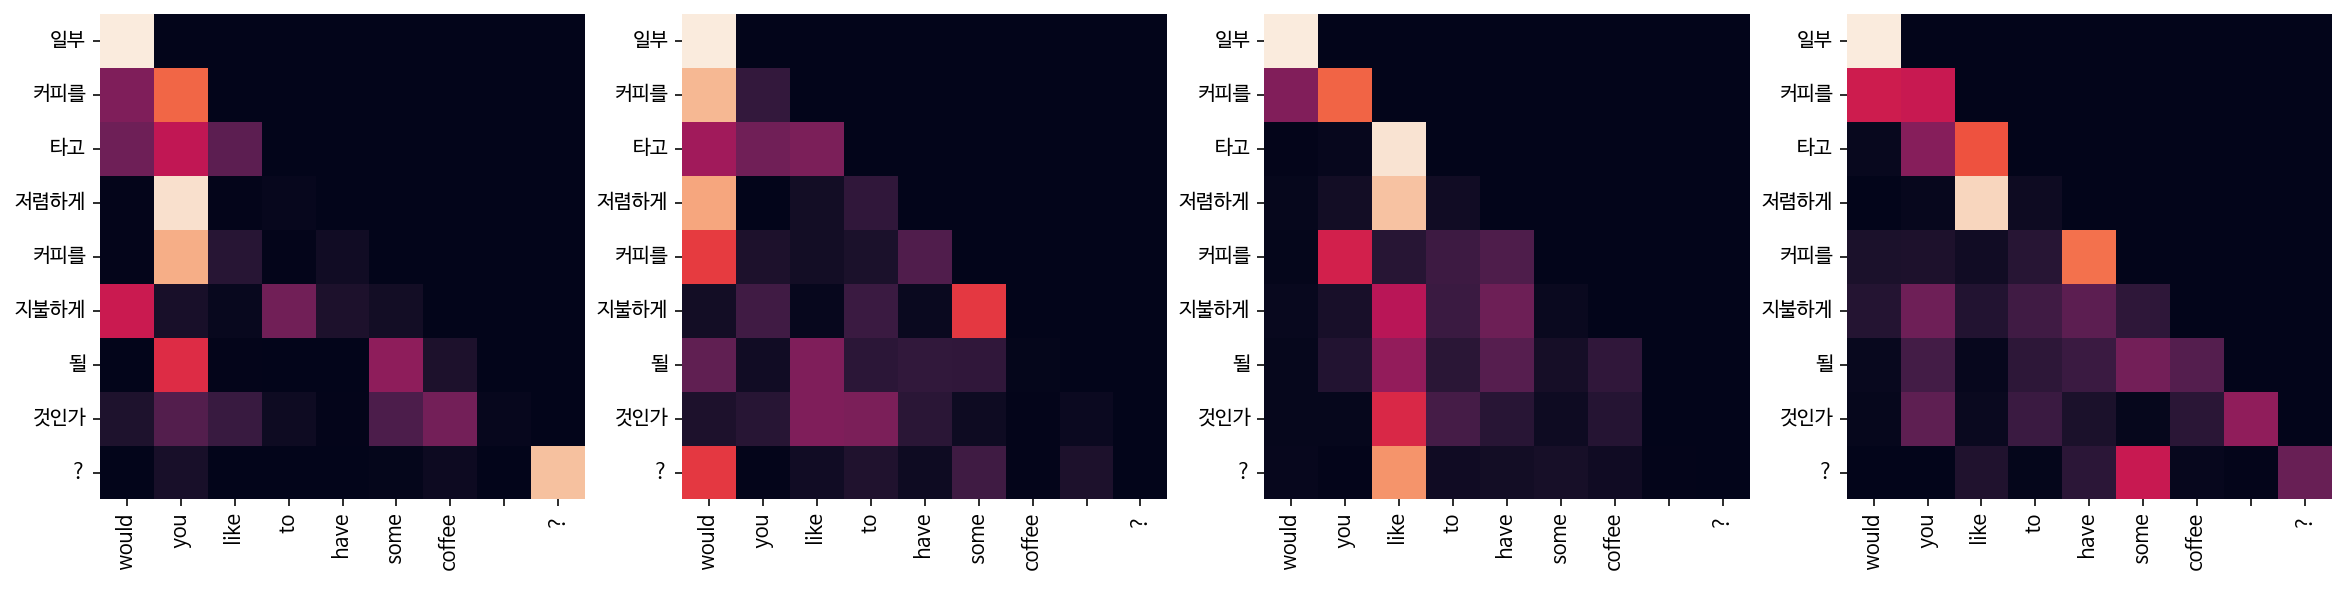

In [58]:
# 매 Epoch 마다 제시된 예문에 대한 번역 생성시각화
for example in examples:
    translate(example, transformer, en_tokenizer, ko_tokenizer, plot_attention=True)

In [ ]:
from datasets import load_metric

bleu = load_metric("bleu")
predictions = [["I", "have", "thirty", "six", "years"]] 
references = [
    [["I", "am", "thirty", "six", "years", "old"], ["I", "am", "thirty", "six"]]
]
bleu.compute(predictions=predictions, references=references)